# Detecting Anomaly in ECG Data Using AutoEncoder with PyTorch

### Introduction

The project "Detecting Anomaly in ECG Data Using AutoEncoder with PyTorch" is designed to revolutionize cardiac health monitoring by integrating advanced anomaly detection directly into patient care models. This initiative seeks to harness the power of machine learning, specifically using PyTorch, to analyze electrocardiogram (ECG) data in real-time. The project's goal is to create a system that not only tracks heart activity but also instantly alerts patients and healthcare providers of any irregularities, facilitating immediate intervention.

### Problem Statement

Cardiovascular diseases remain a leading cause of death worldwide, and early detection is crucial for effective management and treatment. Current ECG analysis methods, primarily manual and conducted in clinical settings, often lead to delays in identifying cardiac anomalies. These delays can be detrimental, especially in acute cases where every moment counts. The project addresses the need for a real-time, automated, and reliable solution that empowers patients with immediate feedback on their cardiac health, potentially saving lives through timely alerts.

### Development Method

The development of this patient-centric ECG monitoring system involves the following key steps:

1. **Data Preparation and Preprocessing**: ECG data is meticulously prepared and preprocessed for model training. This involves normalizing the data, segmenting it into readable sequences, and ensuring that it is free from noise and artifacts that could affect model accuracy.

2. **Model Architecture - Autoencoder LSTM**: The project employs an Autoencoder LSTM network architecture, realized through the PyTorch framework. This architecture is chosen for its ability to learn complex temporal patterns in ECG data. The LSTM autoencoder comprises an encoding stage to compress the input data into a condensed representation and a decoding stage to reconstruct the data from this representation.

3. **Training with Normal ECG Data**: The model is trained exclusively on datasets of normal ECG readings. This approach enables the model to learn a baseline of what constitutes a normal heart rhythm.

4. **Real-time Anomaly Detection and Alert System**: The trained model continuously analyzes incoming ECG data. The focus is on the reconstruction error: significant deviations from the learned normal patterns are flagged as anomalies. When anomalies are detected, the system immediately triggers alerts to the patient and healthcare providers, enabling swift medical response.

This proactive, real-time monitoring and alert system represents a significant leap in patient-centered cardiac care, potentially reducing the risk of late detection in cardiac events.

### Import required libraries

In [1]:
# Importing necessary libraries for TensorFlow, pandas, numpy, and matplotlib
#import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

# Importing the PyTorch library
import torch

# Importing additional libraries for data manipulation, visualization, and machine learning
import copy
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split

# Importing PyTorch modules for neural network implementation
from torch import nn, optim
import torch.nn.functional as F
import torch.nn as nn

# Ignoring warnings to enhance code cleanliness
import warnings
warnings.filterwarnings('ignore')

/Users/elizabeth/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/elizabeth/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/Users/elizabeth/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import pickle

In [3]:
pwd

'/Users/elizabeth/Documents/M_CGM_VAE/Detecting-Anomaly-in-ECG-Data-Using-AutoEncoder-with-PyTorch'

In [4]:
temp=pd.load(open('processed_sim_data/date_correctedbreakfast_week_adult#003.csv','rb'))

AttributeError: module 'pandas' has no attribute 'load'

In [7]:
#users_with_OGTT = meals.userID.unique()
def get_isi_and_bcell_function(pat_stats,info,meals,ins_var =  'Insulin_uuml' ,interpolate = True):
    users_with_OGTT = pat_stats.index.unique()
    missing = ' '
    count = 0
    
    for user in users_with_OGTT:
        info_df = info[info.userID==user]

        count_i = 0
        b_cell =[]
        for date in info_df.date.unique():
            temp = info_df[info_df.date ==date]
            try:
                temp30 = temp[temp.timepoint_mins==30]
                temp0 = temp[temp.timepoint_mins==0]
                C = list(temp30[temp30.parameter ==ins_var].value)[0]-list(temp0[temp0.parameter ==ins_var].value)[0]
                G  = list(temp30[temp30.parameter =='OGTT'].value)[0]-list(temp0[temp0.parameter =='OGTT'].value)[0]
                bcell30  =C/G
               
                pat_stats.loc[user,'Bcell30']  = bcell30
                print(user)
                print(bcell30)
                b_cell.append(bcell30)
                
            except:
                g=0
             


        count = 0
        ISI_list=[]
        for date in info_df.date.unique():
            try:
                temp = info_df[info_df.date ==date]
                temp0 = temp[temp.timepoint_mins==0]
                FPG = list(temp[temp.parameter =='FBG'].value)[0]
                #FPG = list(temp0[temp0.parameter=='OGTT'].value)[0]
                FPI  = list(temp0[temp0.parameter =='Insulin_uuml'].value)[0]

                if interpolate==False:
                    mean_insulin=np.mean(temp[temp.parameter=='Insulin_uuml'].value)
                    mean_glucose=np.mean(temp[temp.parameter=='OGTT'].value)
                else:
                    vals =list(temp[temp.parameter=='OGTT'].value)

                    vals.append((vals[1]+(vals[2]-vals[1])/3))
                    vals.append((vals[1]+2*(vals[2]-vals[1])/3))
                    mean_glucose=np.mean(vals)

                    vals =list(temp[temp.parameter=='Insulin_uuml'].value)
                    vals.append((vals[1]+(vals[2]-vals[1])/3))
                    vals.append((vals[1]+2*(vals[2]-vals[1])/3))
                    mean_insulin=np.mean(vals)

                ISI = 10000/np.sqrt((FPG*FPI)*mean_insulin*mean_glucose)
                pat_stats.loc[user,'ISI']  = ISI
                count = count+1
                #date_cgm= list(meals[meals.userID==user].Date)[0]

                #days_diff=np.abs((datetime.datetime.strptime(date, '%Y-%m-%d').date()-date_cgm).days)
                #if days_diff<60:
                ISI_list.append(ISI)
            except:  
                x=0
        if count>1:

            print(ISI_list)
    return pat_stats

In [8]:
def import_data():    
    cgm = pd.read_csv('../Data/cgm.txt',  delimiter = "\t",header = 0)
    info = pd.read_csv('../Data/s8.txt',  delimiter = "\t",header = 0)
    meals = pd.read_csv('../Data/s5.txt',  delimiter = "\t",header = 0)
    import sqlite3
    dat = sqlite3.connect('../Data/pbio.2005143.s014.db')
    query = dat.execute("SELECT * From clinical")
    cols = [column[0] for column in query.description]
    results= pd.DataFrame.from_records(data = query.fetchall(), columns = cols)
    
    meals.time = pd.to_datetime(meals.time)
    meals['Date'] = meals.time.dt.date
    
    cgm.DisplayTime = pd.to_datetime(cgm.DisplayTime)
    cgm['Date'] = cgm.DisplayTime.dt.date
    return cgm, info, meals, results

cgm, info, meals, pat_stats = import_data()
cgm['Time'] = cgm.DisplayTime.dt.time
subjects = cgm.subjectId.unique()
#users_with_OGTT = meals.userID.unique()
#users = pat_stats[pat_stats['diagnosis']=='diabetic'].userID.unique()
pat_stats = pat_stats.set_index('userID')
pat_stats = get_isi_and_bcell_function(pat_stats,info,meals)
pat_stats = pat_stats[pat_stats['insulin']>0]
pat_stats = pat_stats[pat_stats['Bcell30']>0]
cgm = cgm[cgm.subjectId.isin(pat_stats.index.unique())]
import numpy as np
subject_dict = {}
for subject in cgm.subjectId.unique():
    temp = cgm[cgm.subjectId==subject]
    subject_dict[subject] = {}
    subject_dict[subject]['Dates'] = temp.Date.nunique()
    subject_dict[subject]['full days']=len(temp.groupby('Date').count()[temp.groupby('Date').count().InternalTime>280])
    subject_dict[subject]['days>270']=len(temp.groupby('Date').count()[temp.groupby('Date').count().InternalTime>270])
    subject_dict[subject]['mean']=np.round(np.mean(temp.groupby('Date').count().InternalTime))
#pd.DataFrame(subject_dict).transpose()

1636-69-001
0.19000000000000003
1636-69-032
0.6236363636363638
1636-69-035
0.40625
1636-69-053
1.2378787878787878
1636-69-060
2.4799999999999995
1636-69-064
1.7571428571428573
1636-69-069
1.8122807017543858
1636-69-090
0.5885245901639345
1636-69-091
-19.375
1636-69-100
0.48723404255319147
1636-69-104
0.9587301587301588
1636-69-111
3.9846153846153842
1636-69-114
0.8200000000000001
1636-69-123
0.7126984126984127
1636-70-1003
0.8999999999999999
1636-70-1010
0.3660377358490566
2133-001
1.82
2133-006
1.2894736842105263
2133-007
0.394927536231884
2133-009
2.0304347826086953
2133-010
1.1592105263157897
2133-011
1.234
2133-012
0.8614035087719298
2133-013
0.28545454545454546
2133-015
0.4060240963855422
2133-017
1.3971014492753624
2133-018
0.4356164383561644
2133-021
0.25283018867924534
2133-022
1.1026315789473684
2133-023
0.41891891891891897
2133-024
1.3700000000000003
2133-025
0.13877551020408166
2133-026
1.1108695652173914
2133-027
0.6473118279569893
2133-028
0.2467741935483871
2133-030
0.652

In [135]:
y_list = []
labels = []
i=0
for sub in cgm.subjectId.unique():
    i+=1
    date_df = cgm[cgm.subjectId==sub]
    for date in date_df.Date.unique():
        temp = date_df[date_df.Date==date]
        temp = temp[temp.GlucoseValue !='Low']
        y = temp.GlucoseValue.values
        
        y = [int(x) for x in y]
        if len(y)>260:
            y_list.append(y[:12*3])
            
            
            if pat_stats.loc[sub]['diagnosis']== 'non-diabetic':
                labels.append(0)
            elif pat_stats.loc[sub]['diagnosis']== 'diabetic':
                labels.append(2)
            else:
                labels.append(1)

In [136]:
X = np.asarray(y_list)
X_new=(X-X.min())/(X.max()-X.min())

In [137]:
len(labels)

164

In [138]:
'''import pandas as pd

df = pd.read_csv('processed_sim_data/date_correctedbreakfast_week_adult#003.csv')
df2 = pd.read_csv('processed_sim_data/date_correctedbreakfast_week_adult#008.csv')
df3 = pd.read_csv('processed_sim_data/date_correctedbreakfast_week_adult#005.csv')
'''

"import pandas as pd\n\ndf = pd.read_csv('processed_sim_data/date_correctedbreakfast_week_adult#003.csv')\ndf2 = pd.read_csv('processed_sim_data/date_correctedbreakfast_week_adult#008.csv')\ndf3 = pd.read_csv('processed_sim_data/date_correctedbreakfast_week_adult#005.csv')\n"

In [139]:
'''
df_ = pd.concat([df,df2])
df_ = pd.concat([df_,df3])'''

'\ndf_ = pd.concat([df,df2])\ndf_ = pd.concat([df_,df3])'

In [140]:
'''X = np.array(df['CGM'][:3456]).reshape(96,36)
Y = np.array(df2['CGM'][:3456]).reshape(96,36)
X = X-np.mean(X)
Y = Y-np.mean(Y)
X = X/60
Y=Y/60'''

"X = np.array(df['CGM'][:3456]).reshape(96,36)\nY = np.array(df2['CGM'][:3456]).reshape(96,36)\nX = X-np.mean(X)\nY = Y-np.mean(Y)\nX = X/60\nY=Y/60"

In [141]:
'''X = np.array(df_['CGM'][:122*93]).reshape(93,122)
Y = np.array(df_['CGM'][:122*93]).reshape(93,122)
X = X-np.mean(X)
Y = Y-np.mean(Y)
X = X/60
Y=Y/60'''

"X = np.array(df_['CGM'][:122*93]).reshape(93,122)\nY = np.array(df_['CGM'][:122*93]).reshape(93,122)\nX = X-np.mean(X)\nY = Y-np.mean(Y)\nX = X/60\nY=Y/60"

In [142]:
len(df['CGM'][:3456])/12

KeyError: 'CGM'

In [143]:
12*288

3456

In [144]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,259
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,...,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000
mean,0.272633,0.271967,0.270476,0.270263,0.269544,0.267547,0.267228,0.266003,0.267547,0.269278,...,0.288023,0.285467,0.282751,0.281659,0.282032,0.279982,0.279716,0.279369,0.279050,0.280142
std,0.096085,0.093782,0.093144,0.088895,0.087691,0.085959,0.085158,0.088244,0.086705,0.088257,...,0.109849,0.110175,0.108367,0.106185,0.105492,0.103854,0.103449,0.102460,0.100574,0.098987
min,0.074236,0.061135,0.052402,0.043668,0.039301,0.039301,0.034934,0.030568,0.021834,0.013100,...,0.082969,0.087336,0.069869,0.065502,0.061135,0.074236,0.078603,0.082969,0.074236,0.087336
25%,0.213974,0.213974,0.209607,0.217249,0.218341,0.218341,0.213974,0.213974,0.212882,0.209607,...,0.218341,0.213974,0.213974,0.217249,0.218341,0.221616,0.222707,0.217249,0.218341,0.218341
50%,0.266376,0.264192,0.262009,0.262009,0.257642,0.262009,0.257642,0.262009,0.262009,0.262009,...,0.266376,0.266376,0.270742,0.262009,0.262009,0.257642,0.259825,0.264192,0.266376,0.266376
75%,0.318777,0.318777,0.327511,0.320961,0.323144,0.319869,0.318777,0.315502,0.316594,0.328603,...,0.341703,0.341703,0.336245,0.328603,0.324236,0.315502,0.318777,0.331878,0.324236,0.323144
max,0.585153,0.585153,0.580786,0.580786,0.585153,0.563319,0.554585,0.541485,0.532751,0.532751,...,0.777293,0.755459,0.737991,0.724891,0.729258,0.729258,0.724891,0.716157,0.703057,0.694323


In [115]:
df.isna().sum()

0      0
1      0
2      0
3      0
4      0
      ..
255    0
256    0
257    0
258    0
259    0
Length: 260, dtype: int64

In [6]:
df.dtypes

0      float64
1      float64
2      float64
3      float64
4      float64
        ...   
136    float64
137    float64
138    float64
139    float64
140    float64
Length: 141, dtype: object

In [68]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [69]:
df.target.value_counts()

target
1.0    2919
0.0    2079
Name: count, dtype: int64

In [21]:
df = pd.DataFrame(X_new)

In [70]:
df

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,0.608558,-0.335651,-0.990948,-1.784153,-2.626145,-2.957065,-2.931897,-2.664816,-2.090137,-1.461841,...,1.757705,2.291923,2.704595,2.451519,2.017396,1.704358,1.688542,1.629593,1.342651,0.0
4994,-2.060402,-2.860116,-3.405074,-3.748719,-3.513561,-3.006545,-2.234850,-1.593270,-1.075279,-0.976047,...,1.388947,2.079675,2.433375,2.159484,1.819747,1.534767,1.696818,1.483832,1.047612,0.0
4995,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,-0.645363,...,-0.472419,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334,0.0
4996,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,-1.374321,...,1.258419,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932,0.0


In [32]:
classes = 3

def plot_ecg(data, class_name, ax, n_steps=10):
    # Convert data to a DataFrame
    time_series_df = pd.DataFrame(data)

    # Apply a moving average for smoothing
    smooth_data = time_series_df.rolling(window=n_steps, min_periods=1).mean()

    # Calculate upper and lower bounds for confidence interval
    deviation = time_series_df.rolling(window=n_steps, min_periods=1).std()
    upper_bound = smooth_data + deviation
    lower_bound = smooth_data - deviation

    # Plot the smoothed data
    ax.plot(smooth_data, color='black', linewidth=2)

    # Plot the confidence interval
    ax.fill_between(time_series_df.index, lower_bound[0], upper_bound[0], color='black', alpha=0.2)

    # Set the title
    ax.set_title(class_name)

TypeError: 'int' object is not iterable

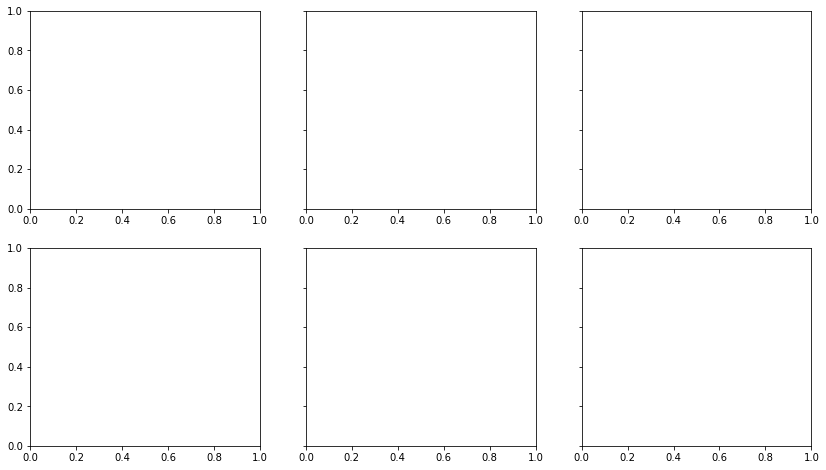

In [34]:
# Plotting setup
fig, axs = plt.subplots(
    nrows=3 // 3 + 1,
    ncols=3,
    sharey=True,
    figsize=(14, 8)
)

# Plot for each class
for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = df[df.target == cls].drop(labels='target', axis=1).mean(axis=0).to_numpy()
    plot_ecg(X.mean(axis=0), cls, ax)  # Using 'cls' directly as class name

# Adjust layout and remove extra axes
fig.delaxes(axs.flat[-1])
fig.tight_layout()

plt.show()

### Preparation and Splitting of ECG Data for Anomaly Detection Using PyTorch


The code in this section outlines the methodical process of preparing and splitting an Electrocardiogram (ECG) dataset for the purpose of anomaly detection in a PyTorch environment. The primary goal is to segregate the dataset into distinct categories for training, validation, and testing, focusing on both normal and anomalous ECG readings.

1. **Data Segregation into Normal and Anomalous Groups**:
    - `normal_df` is created by filtering the ECG dataset to include only the data points where the target value indicates a normal reading. This subset excludes the 'target' column.
    - `anomaly_df` is similarly created by filtering for anomalous readings (where the target value does not indicate normal).

2. **Initial Train-Validation Split**:
    - The 'normal_df' dataset, which includes only normal readings, is split into training and validation sets. This is done using a 15% allocation for the validation set, ensuring that the majority of normal data is used for training. The use of `random_state=42` ensures that the split is reproducible.

3. **Splitting Validation Set for Test Data**:
    - The previously obtained validation set is further divided to create a test set. Here, 30% of the validation set is allocated for testing. This step ensures that there is a separate test dataset to evaluate the model's performance.

4. **Function to Create PyTorch Dataset**:
    - The `create_dataset` function converts a given DataFrame into a format suitable for PyTorch modeling. This includes converting the DataFrame into a list of sequences (each sequence being a list of floats), transforming these sequences into PyTorch tensors, and determining the dataset's dimensions in terms of sequence length and number of features.

5. **Dataset Creation for Different Sets**:
    - Using the `create_dataset` function, distinct datasets are created for training, validation, normal test cases, and anomalous test cases. This includes capturing the sequence length and number of features from the training dataset for use in model architecture.

This comprehensive preparatory process is crucial for the subsequent stages of model training and evaluation in detecting anomalies in ECG data.

In [145]:
X = X_new[:100]
Y=X_new[100:]

In [146]:
Y

array([[0.29943503, 0.29943503, 0.29943503, ..., 0.34463277, 0.33898305,
        0.33333333],
       [0.37288136, 0.37853107, 0.38418079, ..., 0.36158192, 0.37288136,
        0.37853107],
       [0.41242938, 0.40677966, 0.39548023, ..., 0.44067797, 0.40677966,
        0.37853107],
       ...,
       [0.3220339 , 0.3220339 , 0.3220339 , ..., 0.25988701, 0.25988701,
        0.25988701],
       [0.23728814, 0.25423729, 0.27118644, ..., 0.23728814, 0.23163842,
        0.23163842],
       [0.31638418, 0.31073446, 0.30508475, ..., 0.20903955, 0.21468927,
        0.20903955]])

In [147]:
# Splitting the Dataset

# Initial Train-Validation Split:
# The dataset 'normal_df' is divided into training and validation sets.
# 15% of the data is allocated to the validation set.
# The use of 'random_state=42' ensures reproducibility.

train_df, val_df = train_test_split(
  X,
  test_size=0.15,
  random_state=42
)

# Further Splitting for Validation and Test:
# The validation set obtained in the previous step is further split into validation and test sets.
# 33% of the validation set is allocated to the test set.
# The same 'random_state=42' is used for consistency in randomization.

val_df, test_df = train_test_split(
  Y,
  test_size=0.30,
  random_state=42
)

In [148]:
'''# Splitting the Dataset

# Initial Train-Validation Split:
# The dataset 'normal_df' is divided into training and validation sets.
# 15% of the data is allocated to the validation set.
# The use of 'random_state=42' ensures reproducibility.

train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=42
)

# Further Splitting for Validation and Test:
# The validation set obtained in the previous step is further split into validation and test sets.
# 33% of the validation set is allocated to the test set.
# The same 'random_state=42' is used for consistency in randomization.

val_df, test_df = train_test_split(
  val_df,
  test_size=0.30,
  random_state=42
)'''

"# Splitting the Dataset\n\n# Initial Train-Validation Split:\n# The dataset 'normal_df' is divided into training and validation sets.\n# 15% of the data is allocated to the validation set.\n# The use of 'random_state=42' ensures reproducibility.\n\ntrain_df, val_df = train_test_split(\n  normal_df,\n  test_size=0.15,\n  random_state=42\n)\n\n# Further Splitting for Validation and Test:\n# The validation set obtained in the previous step is further split into validation and test sets.\n# 33% of the validation set is allocated to the test set.\n# The same 'random_state=42' is used for consistency in randomization.\n\nval_df, test_df = train_test_split(\n  val_df,\n  test_size=0.30,\n  random_state=42\n)"

In [149]:
# Function to Create a Dataset
def create_dataset(dfv):
    # Convert DataFrame to a list of sequences, each represented as a list of floats
    #sequences = df.astype(np.float32).to_numpy().tolist()
    sequences=dfv
    # Convert sequences to PyTorch tensors, each with shape (sequence_length, 1, num_features)
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

    # Extract dimensions of the dataset
    n_seq, seq_len, n_features = torch.stack(dataset).shape

    # Return the dataset, sequence length, and number of features
    return dataset, seq_len, n_features

In [150]:
# Create the training dataset from train_df
train_dataset, seq_len, n_features = create_dataset(train_df)

# Create the validation dataset from val_df
val_dataset, _, _ = create_dataset(val_df)

# Create the test dataset for normal cases from test_df
test_normal_dataset, _, _ = create_dataset(test_df)

# Create the test dataset for anomalous cases from anomaly_df
#test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

### Implementation of LSTM-Based Autoencoder for ECG Anomaly Detection in PyTorch

The code in this section is an implementation of an LSTM-based Autoencoder neural network in PyTorch, specifically designed for the task of anomaly detection in ECG data. The Autoencoder is composed of two primary components: the Encoder and the Decoder, each defined as a subclass of `nn.Module`.

1. **Encoder Class**:
    - **Purpose**: To compress the input ECG sequence into a lower-dimensional representation.
    - **Architecture**: Comprises two LSTM layers. The first LSTM layer takes the original ECG features as input and outputs to the second LSTM layer, which further compresses the information to an embedding dimension.
    - **Parameters**: Accepts sequence length, number of features, and an optional embedding dimension (default set to 64).
    - **Forward Method**: Defines the data flow through the encoder, reshaping and passing the input through the LSTM layers to produce the encoded representation.

2. **Decoder Class**:
    - **Purpose**: To reconstruct the ECG sequence from the encoded representation.
    - **Architecture**: Mirrors the encoder with two LSTM layers, followed by a linear output layer to generate the reconstructed ECG sequence.
    - **Parameters**: Accepts sequence length, input dimension (matching the encoder's embedding dimension), and number of features.
    - **Forward Method**: Outlines the process of repeating the encoded representation, passing it through the LSTM layers, and finally through the output layer to reconstruct the data.

3. **Autoencoder Class**:
    - **Integration of Encoder and Decoder**: This class combines the Encoder and Decoder into a single model. It initializes both components with the given sequence length, number of features, and embedding dimension.
    - **Forward Method**: Describes the complete forward pass of the Autoencoder, encoding the input and then decoding it to produce the reconstructed output.

4. **Model Initialization and Device Assignment**:
    - The Autoencoder model is instantiated with specified sequence length, number of features, and an embedding dimension of 128.
    - The code dynamically assigns the model to run on GPU if available (`cuda`), otherwise on CPU (`cpu`), optimizing computational efficiency.

This implementation leverages the sequential data processing capability of LSTM networks, making it highly suitable for time-series data like ECG. By learning to reconstruct normal ECG sequences, the model can subsequently identify anomalies by detecting significant deviations in the reconstruction of new data, thus serving as an effective tool for real-time anomaly detection in cardiac monitoring.

In [151]:
embdi = 12
class Encoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=embdi):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        '''self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )'''

        self.rnn2 = nn.LSTM(
          input_size=n_features,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )

    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))

        #x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)

        return hidden_n.reshape((self.n_features, self.embedding_dim))

In [152]:
class Decoder(nn.Module):

    def __init__(self, seq_len, input_dim=embdi, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features =  input_dim, n_features

        '''self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )
        '''
        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))

        #x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))

        return self.output_layer(x)

In [153]:
class Autoencoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=embdi):
        super(Autoencoder, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [154]:
np.shape(X)

(100, 36)

In [125]:
n_features

1

### Training and Visualization of ECG Autoencoder Model in PyTorch

In [158]:
def plot_input_reconstruction(model, dataset, epoch):
    model = model.eval()

    plt.figure(figsize=(10, 5))

    # Take the first sequence from the dataset
    seq_true = dataset[2].to(device)
    seq_pred = model(seq_true)

    with torch.no_grad():
        # Squeeze the sequences to ensure they are 1-dimensional
        input_sequence = seq_true.squeeze().cpu().numpy()
        reconstruction_sequence = seq_pred.squeeze().cpu().numpy()

        # Check the shape after squeezing
        if input_sequence.ndim != 1 or reconstruction_sequence.ndim != 1:
            raise ValueError("Input and reconstruction sequences must be 1-dimensional after squeezing.")

        # Plotting the sequences
        plt.plot(input_sequence, label='Input Sequence', color='black')
        plt.plot(reconstruction_sequence, label='Reconstruction Sequence', color='red')
        plt.fill_between(range(len(input_sequence)), input_sequence, reconstruction_sequence, color='gray', alpha=0.5)

        plt.title(f'Input vs Reconstruction - Epoch {epoch}')
        plt.legend()
        plt.show()



import torch
import numpy as np
import copy

def train_model(model, train_dataset, val_dataset, n_epochs, save_path):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)#, weight_decay=1e-4)
    criterion = torch.nn.L1Loss(reduction='sum').to(device)
    history = {'train': [], 'val': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(1, n_epochs + 1):
        model.train()

        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()

            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            # Save the best model weights
            print("Saving best model")
            torch.save(model.state_dict(), save_path)

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

        if epoch == 1 or epoch % 20== 0:
            plot_input_reconstruction(model, val_dataset, epoch)

    # Load the best model weights before returning
    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [156]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(seq_len, n_features, int(embdi))
model = model.to(device)

Saving best model
Epoch 1: train loss 1.08755343486281 val loss 1.0683362380546682


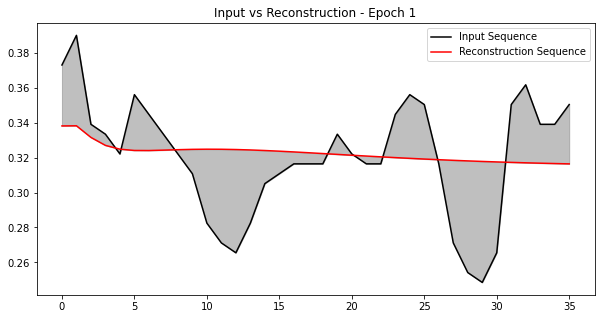

Saving best model
Epoch 2: train loss 1.0718736311968635 val loss 1.0629812563166898
Saving best model
Epoch 3: train loss 1.0682241036611444 val loss 1.0616467815988204
Saving best model
Epoch 4: train loss 1.0667968935826246 val loss 1.0600787722012577
Saving best model
Epoch 5: train loss 1.064741751726936 val loss 1.058253307202283
Epoch 6: train loss 1.0630586024592905 val loss 1.058313767173711
Saving best model
Epoch 7: train loss 1.0624441188924454 val loss 1.0564488363616606
Epoch 8: train loss 1.0606939711991479 val loss 1.056598102345186
Saving best model
Epoch 9: train loss 1.060658217528287 val loss 1.0544336492524427
Epoch 10: train loss 1.0590810239315034 val loss 1.0549421352498671
Epoch 11: train loss 1.0590730193783255 val loss 1.055154168079881
Epoch 12: train loss 1.0588372023666606 val loss 1.0549872098600164
Epoch 13: train loss 1.0579977719222797 val loss 1.0545123748919543
Saving best model
Epoch 14: train loss 1.0576622524682213 val loss 1.0543568274554085
Savi

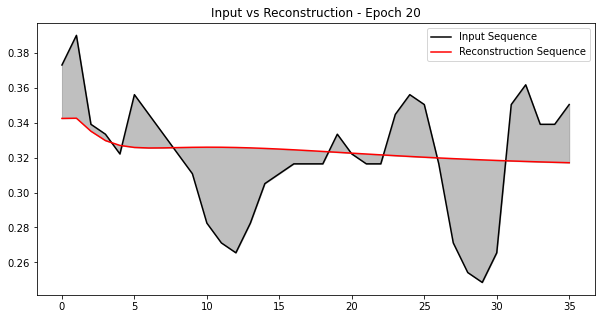

Saving best model
Epoch 21: train loss 1.0525930264416863 val loss 1.0485109739443834
Saving best model
Epoch 22: train loss 1.0527695526094998 val loss 1.0483196588123547
Epoch 23: train loss 1.0526806042474859 val loss 1.0513955852564643
Saving best model
Epoch 24: train loss 1.052130093644647 val loss 1.047661963631125
Epoch 25: train loss 1.0510739361538606 val loss 1.0484996907851276
Saving best model
Epoch 26: train loss 1.0508604239015018 val loss 1.0470001308357015
Saving best model
Epoch 27: train loss 1.0494199181304258 val loss 1.0454937990973978
Epoch 28: train loss 1.0488647972836214 val loss 1.0460697878809537
Epoch 29: train loss 1.048339556946474 val loss 1.045687427590875
Saving best model
Epoch 30: train loss 1.0477046405567843 val loss 1.0450681514599744
Epoch 31: train loss 1.0480418454198277 val loss 1.046733658103382
Epoch 32: train loss 1.047476639467127 val loss 1.0456932106438805
Epoch 33: train loss 1.0474890358307782 val loss 1.0467644119963926
Saving best mo

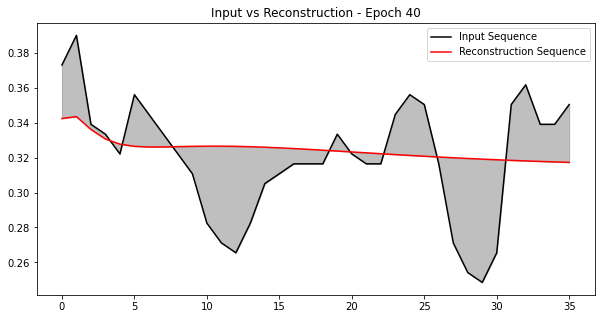

Epoch 41: train loss 1.0445756396826575 val loss 1.0424301484051872
Saving best model
Epoch 42: train loss 1.044283658616683 val loss 1.0410455402205971
Saving best model
Epoch 43: train loss 1.0436494529247284 val loss 1.0399081149521996
Epoch 44: train loss 1.0432176761767444 val loss 1.0406191345523386
Epoch 45: train loss 1.0431039357886596 val loss 1.0417793463258183
Epoch 46: train loss 1.0427918192218333 val loss 1.0409676390535691
Epoch 47: train loss 1.042521496029461 val loss 1.0411597800605437
Epoch 48: train loss 1.0421519174295313 val loss 1.040236725877313
Saving best model
Epoch 49: train loss 1.0416527590330908 val loss 1.0391844795030707
Saving best model
Epoch 50: train loss 1.0409569298519807 val loss 1.037358428976115
Saving best model
Epoch 51: train loss 1.0396196624811957 val loss 1.0362542373292587
Saving best model
Epoch 52: train loss 1.0394886665484484 val loss 1.0357738133739023
Saving best model
Epoch 53: train loss 1.0388347716892468 val loss 1.03534409719

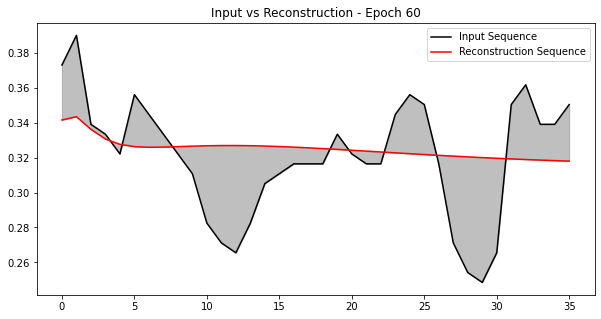

Epoch 61: train loss 1.0364248847260196 val loss 1.034217573965297
Saving best model
Epoch 62: train loss 1.0366530316717484 val loss 1.0322588759310105
Epoch 63: train loss 1.0357344876317416 val loss 1.0323873137726503
Saving best model
Epoch 64: train loss 1.0352261133053724 val loss 1.031106965682086
Saving best model
Epoch 65: train loss 1.0347839744652019 val loss 1.0307797000688665
Saving best model
Epoch 66: train loss 1.0344860301298253 val loss 1.0290162745644065
Epoch 67: train loss 1.0335691441507902 val loss 1.0308901043499217
Epoch 68: train loss 1.0340230471947613 val loss 1.0297406161532683
Epoch 69: train loss 1.0332850158214568 val loss 1.0290754237595727
Saving best model
Epoch 70: train loss 1.0328615486621857 val loss 1.027078693403917
Epoch 71: train loss 1.0321344021488639 val loss 1.0272492079173818
Epoch 72: train loss 1.032037015171612 val loss 1.0279511069550233
Epoch 73: train loss 1.031826272431542 val loss 1.0273661595933579
Saving best model
Epoch 74: tra

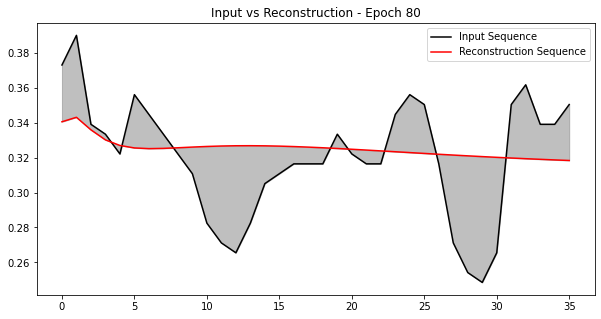

Saving best model
Epoch 81: train loss 1.0291783767587999 val loss 1.0248352212064407
Saving best model
Epoch 82: train loss 1.0285805979195763 val loss 1.0241465827997993
Saving best model
Epoch 83: train loss 1.0282743215560912 val loss 1.023650055773118
Saving best model
Epoch 84: train loss 1.027640600414837 val loss 1.0236494393909679
Saving best model
Epoch 85: train loss 1.0276255316594067 val loss 1.0227337258703568
Saving best model
Epoch 86: train loss 1.0266117173082687 val loss 1.0223847427788904
Epoch 87: train loss 1.0267762047403 val loss 1.0233925423201393
Epoch 88: train loss 1.0269113698426415 val loss 1.0228411015342265
Epoch 89: train loss 1.0258369968217962 val loss 1.0224485428894268
Saving best model
Epoch 90: train loss 1.0255602591177997 val loss 1.0217196860734155
Saving best model
Epoch 91: train loss 1.0250802993774415 val loss 1.0209148063379176
Saving best model
Epoch 92: train loss 1.0247786897070268 val loss 1.0195327541407417
Epoch 93: train loss 1.0244

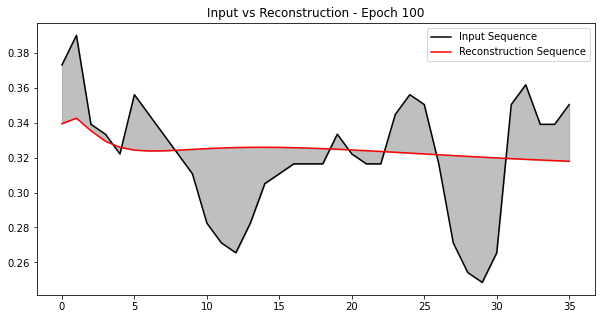

Epoch 101: train loss 1.0213260468314675 val loss 1.0180490059011122
Saving best model
Epoch 102: train loss 1.021650953503216 val loss 1.0162167836638059
Epoch 103: train loss 1.0213318730101866 val loss 1.0176269124535953
Epoch 104: train loss 1.021584557435092 val loss 1.0164142208940843
Epoch 105: train loss 1.020180682925617 val loss 1.016720751804464
Saving best model
Epoch 106: train loss 1.0206824926769031 val loss 1.0156117060605216
Epoch 107: train loss 1.0193028755047742 val loss 1.0156584196230944
Saving best model
Epoch 108: train loss 1.0195327471284306 val loss 1.0155321727780735
Saving best model
Epoch 109: train loss 1.0195334364386166 val loss 1.0151875211912043
Saving best model
Epoch 110: train loss 1.0200368155451383 val loss 1.014498401038787
Epoch 111: train loss 1.019346817451365 val loss 1.015581790489309
Epoch 112: train loss 1.0184535457807429 val loss 1.0153119721833397
Epoch 113: train loss 1.0176611423492432 val loss 1.015067641174092
Epoch 114: train loss

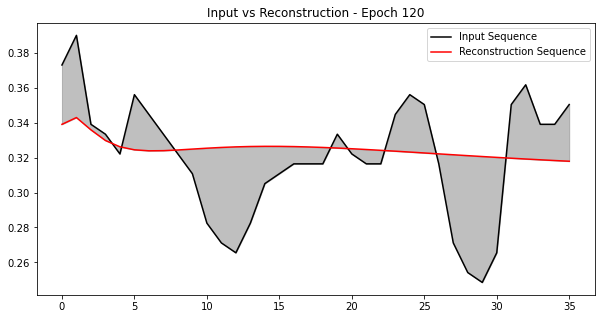

Saving best model
Epoch 121: train loss 1.0161028918098 val loss 1.012276340232176
Epoch 122: train loss 1.0161095776978661 val loss 1.0131845923031078
Saving best model
Epoch 123: train loss 1.0153984238119687 val loss 1.011987165142508
Saving best model
Epoch 124: train loss 1.0160137912806342 val loss 1.0119581496014314
Saving best model
Epoch 125: train loss 1.0151399521266713 val loss 1.0116179908023162
Saving best model
Epoch 126: train loss 1.014990875300239 val loss 1.011307217093075
Epoch 127: train loss 1.0142876221853143 val loss 1.0120849988039802
Saving best model
Epoch 128: train loss 1.013697048145182 val loss 1.0102179762195138
Epoch 129: train loss 1.013543460298987 val loss 1.0111958882387946
Epoch 130: train loss 1.013509495118085 val loss 1.0116385666763081
Epoch 131: train loss 1.0148566649240607 val loss 1.0105090537491968
Saving best model
Epoch 132: train loss 1.0129776484826032 val loss 1.0091578995480257
Epoch 133: train loss 1.013239707666285 val loss 1.01059

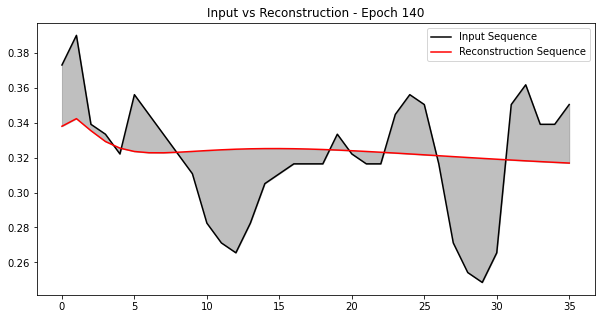

Epoch 141: train loss 1.0124813128920163 val loss 1.0081828576676986
Epoch 142: train loss 1.0113625982228447 val loss 1.0080287007724538
Epoch 143: train loss 1.0110964182545157 val loss 1.0094991792650785
Epoch 144: train loss 1.010543390933205 val loss 1.009747141599655
Saving best model
Epoch 145: train loss 1.0117409450166366 val loss 1.0062921972835766
Epoch 146: train loss 1.0098839843974394 val loss 1.009559708483079
Epoch 147: train loss 1.0110416457933538 val loss 1.0065202260718626
Epoch 148: train loss 1.0101622791851268 val loss 1.007615724030663
Epoch 149: train loss 1.0104186657597036 val loss 1.009742325894973
Saving best model
Epoch 150: train loss 1.0113115531556747 val loss 1.0060286423739264
Epoch 151: train loss 1.0088424328495473 val loss 1.0106290461385952
Epoch 152: train loss 1.010269555274178 val loss 1.0067298717358533
Saving best model
Epoch 153: train loss 1.0079680036096013 val loss 1.0043666758958032
Saving best model
Epoch 154: train loss 1.0085851132869

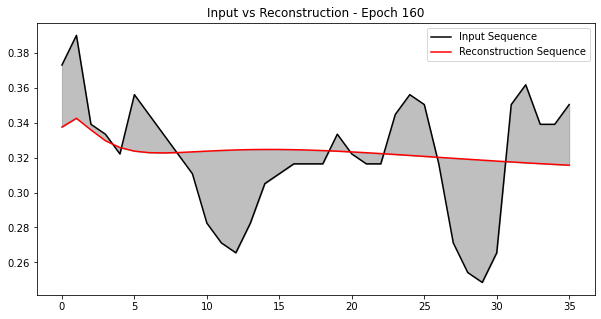

Epoch 161: train loss 1.0069167873438667 val loss 1.0037048711496241
Epoch 162: train loss 1.0067404876737034 val loss 1.0061431209830676
Epoch 163: train loss 1.0075697951457079 val loss 1.0041226053939145
Epoch 164: train loss 1.0059965834898108 val loss 1.0065270499271506
Epoch 165: train loss 1.006873751037261 val loss 1.0030441599733688
Epoch 166: train loss 1.005742222771925 val loss 1.0075107462265913
Epoch 167: train loss 1.0065381905611823 val loss 1.0039321499712326
Epoch 168: train loss 1.004777262140723 val loss 1.0059690352748423
Epoch 169: train loss 1.0059307778582853 val loss 1.0031183207736296
Epoch 170: train loss 1.0043008492273442 val loss 1.0065289800657946
Epoch 171: train loss 1.0056845910408918 val loss 1.0021174956770504
Epoch 172: train loss 1.0044227245975943 val loss 1.0022254985921524
Saving best model
Epoch 173: train loss 1.005075198762557 val loss 1.001916147330228
Epoch 174: train loss 1.0035266998936148 val loss 1.004595455877921
Epoch 175: train loss 

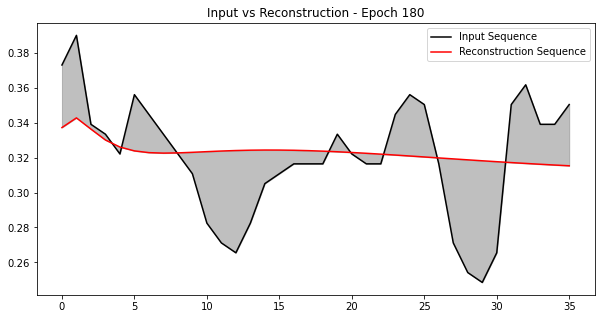

Saving best model
Epoch 181: train loss 1.0038714563145357 val loss 1.000848949656767
Saving best model
Epoch 182: train loss 1.0016956501147327 val loss 0.9968800502664903
Epoch 183: train loss 1.0018555683248183 val loss 1.0037249072509653
Epoch 184: train loss 1.0036077134749468 val loss 1.003501696095747
Epoch 185: train loss 1.0017792112687054 val loss 1.003535715972676
Epoch 186: train loss 1.0035466730594635 val loss 1.0054787474520066
Epoch 187: train loss 1.0030058822211096 val loss 1.0057112593861188
Epoch 188: train loss 1.0032437275437747 val loss 1.0005253896993749
Epoch 189: train loss 1.0003886240370132 val loss 1.0037264839691273
Epoch 190: train loss 1.0035283246461082 val loss 1.0041556302238912
Epoch 191: train loss 1.0017516728709726 val loss 1.0037204328705283
Epoch 192: train loss 1.0020288807504318 val loss 0.9991100107922274
Epoch 193: train loss 0.9994452781537 val loss 1.0018710769274655
Epoch 194: train loss 1.001258595200146 val loss 0.9977622270584107
Epoch

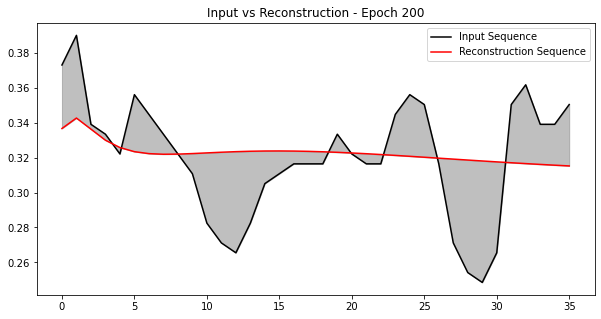

Epoch 201: train loss 0.9994062479804544 val loss 1.0040330864050808
Epoch 202: train loss 1.000939121316461 val loss 0.9972682416439056
Epoch 203: train loss 0.9979656755924224 val loss 1.0015035739716363
Epoch 204: train loss 1.0000103613909552 val loss 1.0039656323545119
Epoch 205: train loss 0.9989725084865795 val loss 1.0026800513267518
Epoch 206: train loss 1.000471752005465 val loss 1.001653589921839
Epoch 207: train loss 0.9989344530245837 val loss 0.9996092216056935
Saving best model
Epoch 208: train loss 0.9979939043521882 val loss 0.9942974904004265
Epoch 209: train loss 0.9964145835708169 val loss 0.9991359572200215
Epoch 210: train loss 0.9976125419139862 val loss 0.9953049621161293
Epoch 211: train loss 0.9970698051592883 val loss 1.000598227802445
Epoch 212: train loss 0.9985302574494306 val loss 1.0009980766212239
Epoch 213: train loss 0.9974015102666967 val loss 1.0014675729414997
Epoch 214: train loss 0.9997414055992575 val loss 1.017934509936501
Saving best model
Epo

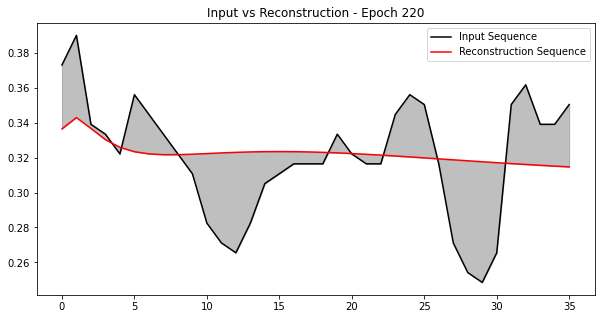

Epoch 221: train loss 0.9955364034456365 val loss 0.9991956065682804
Epoch 222: train loss 0.9980466456974254 val loss 1.0189725840792936
Saving best model
Epoch 223: train loss 1.0007518645595102 val loss 0.990832666088553
Epoch 224: train loss 0.994201534986496 val loss 0.9926832185072058
Epoch 225: train loss 0.9940177768468856 val loss 0.9925611871130327
Epoch 226: train loss 0.9935809047783122 val loss 0.9965276781250448
Epoch 227: train loss 0.9951188893879162 val loss 0.9922105350915124
Epoch 228: train loss 0.9934918151182287 val loss 0.99621462541468
Epoch 229: train loss 0.9948471809134763 val loss 0.9976838949848624
Epoch 230: train loss 0.9941007245989407 val loss 0.9954164219253203
Epoch 231: train loss 0.9943192851894042 val loss 0.9973528365878498
Epoch 232: train loss 0.9937688690774581 val loss 0.9953312957988066
Epoch 233: train loss 0.9931564055821475 val loss 0.9911665860344382
Epoch 234: train loss 0.9916831083157484 val loss 0.9930659732397865
Epoch 235: train los

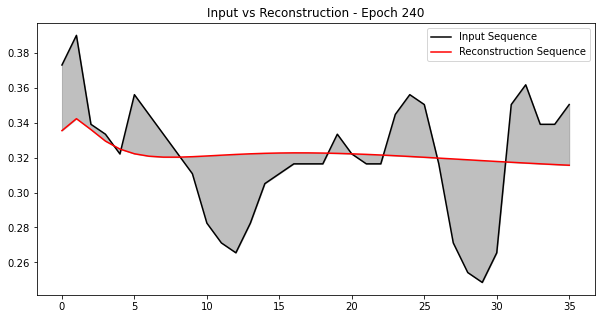

Epoch 241: train loss 0.9914231556303361 val loss 0.992273770886309
Epoch 242: train loss 0.9925818799173131 val loss 0.9952478163382587
Epoch 243: train loss 0.9919589305625243 val loss 0.992080745100975
Epoch 244: train loss 0.991394781365114 val loss 0.989670929312706
Epoch 245: train loss 0.9894554674625397 val loss 0.9904444217681885
Epoch 246: train loss 0.9910565132603926 val loss 0.9937744547339047
Epoch 247: train loss 0.990860573684468 val loss 0.9909376575666315
Epoch 248: train loss 0.9914607430205625 val loss 0.9959675766089383
Epoch 249: train loss 0.990032904288348 val loss 0.991592376723009
Epoch 250: train loss 0.9910215624991585 val loss 0.9933370581444572
Epoch 251: train loss 0.9903175091042238 val loss 0.9906004183432635
Epoch 252: train loss 0.9905727586325477 val loss 0.9979381636661642
Epoch 253: train loss 0.9893048612510457 val loss 0.9883995063164654
Epoch 254: train loss 0.9896818844711079 val loss 0.9913024309803458
Epoch 255: train loss 0.9882312490659602 

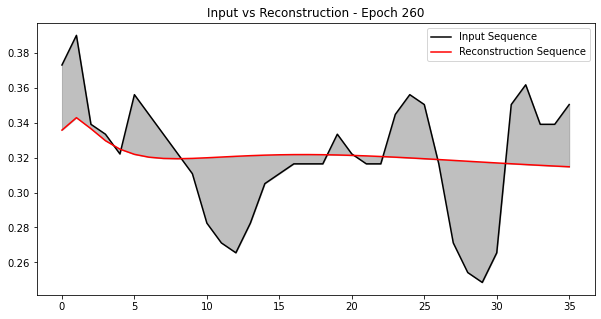

Epoch 261: train loss 0.9872643561924205 val loss 0.9855665310340769
Epoch 262: train loss 0.9849683442536522 val loss 0.9843639861134922
Epoch 263: train loss 0.9882496539284201 val loss 0.9943086650441675
Epoch 264: train loss 0.9868729640455807 val loss 0.9904044051380718
Epoch 265: train loss 0.9931253548930673 val loss 1.0218416866134195
Saving best model
Epoch 266: train loss 0.9958446288810057 val loss 0.9821023725411471
Epoch 267: train loss 0.9864093980368446 val loss 0.9879958413979586
Saving best model
Epoch 268: train loss 0.9847452696631936 val loss 0.980925192026531
Epoch 269: train loss 0.9840041628655265 val loss 0.9817536138436374
Epoch 270: train loss 0.9839195912375169 val loss 0.9824484353556352
Epoch 271: train loss 0.9837248577791102 val loss 0.9872868390644298
Epoch 272: train loss 0.9882356994292315 val loss 1.0131919983555289
Epoch 273: train loss 0.9907350252656376 val loss 0.9823519733022241
Epoch 274: train loss 0.9871444526840659 val loss 0.9890178811900756

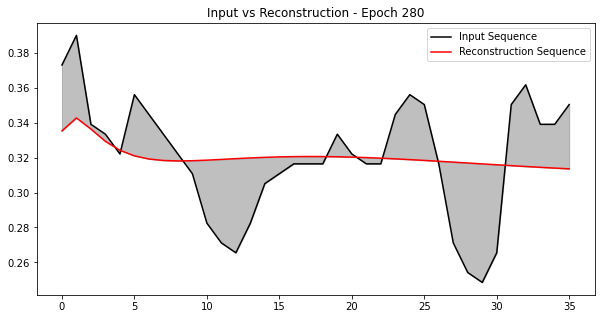

Saving best model
Epoch 281: train loss 0.9824777308632345 val loss 0.9781688888283336
Epoch 282: train loss 0.9825416612274507 val loss 0.9866974124137093
Epoch 283: train loss 0.9851298779249191 val loss 1.0146096578415702
Epoch 284: train loss 0.9885545495678397 val loss 0.9820725181523491
Epoch 285: train loss 0.9833883573027218 val loss 0.9875616510124767
Epoch 286: train loss 0.981998490060077 val loss 0.9815012374344994
Epoch 287: train loss 0.9812706223305534 val loss 0.9840816872961381
Epoch 288: train loss 0.9840924785417668 val loss 0.9894287679125281
Epoch 289: train loss 0.9890007015536814 val loss 1.0268569446661893
Saving best model
Epoch 290: train loss 0.9942587384406258 val loss 0.9774270383750692
Epoch 291: train loss 0.9826680486693101 val loss 0.9861587042317671
Epoch 292: train loss 0.9808265414308099 val loss 0.9810253562296138
Epoch 293: train loss 0.9836969282697229 val loss 0.9864637122434728


In [ ]:
save_path = 'best_model.pth'  # Replace with your actual path
model, history = train_model(model, train_dataset, train_dataset, 1000, save_path)

Saving best model
Epoch 1: train loss 13.50278980030733 val loss 13.365424212287454


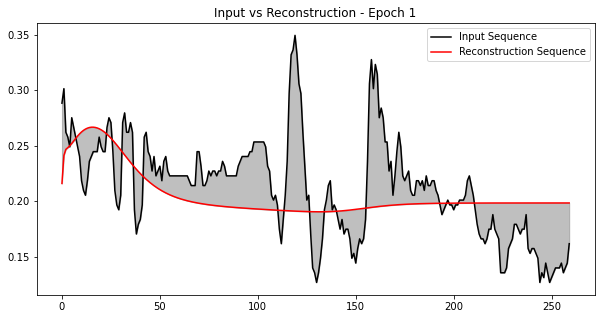

Epoch 2: train loss 13.831418699376723 val loss 14.017150020599365
Epoch 3: train loss 13.96465866986443 val loss 13.801170859617345
Epoch 4: train loss 13.712304608962116 val loss 13.608427350661334
Epoch 5: train loss 13.705018896215103 val loss 13.666762060277602
Epoch 6: train loss 13.71817678563735 val loss 13.623275459513945
Epoch 7: train loss 13.61800952238195 val loss 13.659469935473274
Epoch 8: train loss 13.636301719441134 val loss 13.828530395732207
Epoch 9: train loss 13.58676732007195 val loss 13.443901802511776
Epoch 10: train loss 13.828610229492188 val loss 15.08863442364861
Epoch 11: train loss 14.001214610829074 val loss 14.0768222247853
Epoch 12: train loss 13.975859210070443 val loss 13.687057085598216
Epoch 13: train loss 13.76753277498133 val loss 13.734555794210994
Epoch 14: train loss 13.857906593995935 val loss 13.674791594112621
Epoch 15: train loss 13.762998378978056 val loss 13.988336125542135
Epoch 16: train loss 13.858217963050393 val loss 13.549903157178

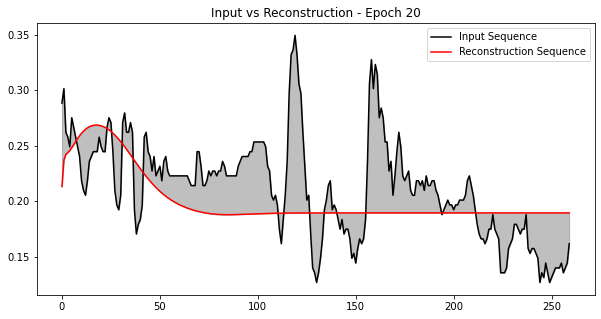

Epoch 21: train loss 13.711940832699046 val loss 13.774942521487965
Epoch 22: train loss 13.684037881739 val loss 13.485910527846393
Epoch 23: train loss 13.485863337797277 val loss 13.44802298265345
Epoch 24: train loss 13.494395766538732 val loss 13.58149979535271
Epoch 25: train loss 13.41257355072919 val loss 13.468022756015554
Epoch 26: train loss 13.401137119181016 val loss 13.53827865263995
Epoch 27: train loss 13.752651203379912 val loss 13.6389084815979
Epoch 28: train loss 13.50967430787928 val loss 13.450783768822165
Epoch 29: train loss 13.565782889197854 val loss 13.545757417117848
Epoch 30: train loss 13.71562781053431 val loss 14.01977305692785
Epoch 31: train loss 14.62049461813534 val loss 16.20406145769007
Epoch 32: train loss 14.533311546550078 val loss 13.638118996339685
Epoch 33: train loss 13.735001003040987 val loss 13.6341947555542
Epoch 34: train loss 13.661768587897805 val loss 13.605154710657457
Epoch 35: train loss 13.546883942099178 val loss 13.560894253674

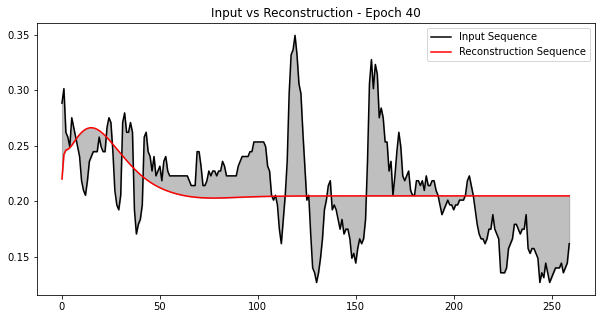

Epoch 41: train loss 13.50158831652473 val loss 13.694432152018827
Epoch 42: train loss 14.286973829830394 val loss 14.055196868672091
Epoch 43: train loss 13.904596844841452 val loss 14.051609274920295
Epoch 44: train loss 13.820612643746768 val loss 13.632313111249138
Epoch 45: train loss 13.724815980125877 val loss 13.652433670268339
Epoch 46: train loss 13.717392455830293 val loss 14.322553988064037
Epoch 47: train loss 13.63908722821404 val loss 13.405908960454605
Epoch 48: train loss 14.346108408535228 val loss 14.320893018385943
Epoch 49: train loss 13.90943183337941 val loss 14.390696295569924
Epoch 50: train loss 14.18948829314288 val loss 14.656496923110064
Epoch 51: train loss 14.187276296054616 val loss 14.985248969582951
Epoch 52: train loss 13.981685728185317 val loss 14.208698166117948
Epoch 53: train loss 13.857194131963393 val loss 14.183935417848474
Epoch 54: train loss 13.789800879534553 val loss 14.20860917147468
Epoch 55: train loss 13.754117640327005 val loss 13.8

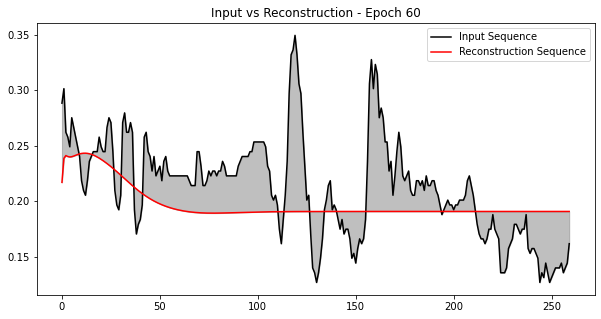

Saving best model
Epoch 61: train loss 13.617073485430549 val loss 13.35492455258089
Epoch 62: train loss 13.681357759587906 val loss 13.496058974546544
Epoch 63: train loss 13.481078770581414 val loss 13.452002903994392
Epoch 64: train loss 13.495554957670324 val loss 14.315441086713005
Epoch 65: train loss 14.432708930969238 val loss 13.958277163786047
Epoch 66: train loss 13.886094199909884 val loss 13.518889702067655
Epoch 67: train loss 13.603345079982981 val loss 13.441194006975959
Saving best model
Epoch 68: train loss 13.535495830984676 val loss 13.303508203169878
Epoch 69: train loss 13.504138172374052 val loss 13.715459644093233
Epoch 70: train loss 14.206220144384048 val loss 13.713688003315646
Epoch 71: train loss 13.523545938379625 val loss 13.409245381635778
Epoch 72: train loss 13.647529416925767 val loss 13.99908712050494
Epoch 73: train loss 14.3158036849078 val loss 14.300490239087273
Epoch 74: train loss 15.49297648598166 val loss 14.839445226332721
Epoch 75: train l

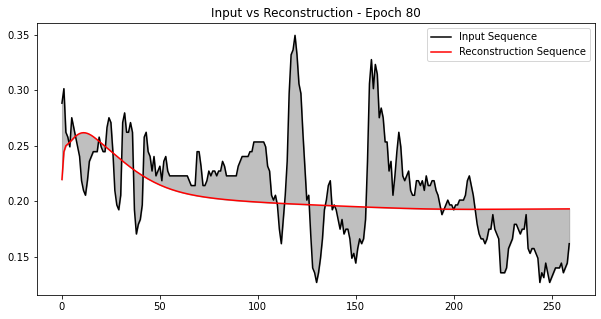

Epoch 81: train loss 13.660997205622056 val loss 13.452714645161349
Epoch 82: train loss 13.927316553452435 val loss 13.678417620939367
Epoch 83: train loss 13.620814665626076 val loss 13.568652307285982
Saving best model
Epoch 84: train loss 13.44322338665233 val loss 13.296996615914738
Epoch 85: train loss 13.362616017285514 val loss 13.368346612593706
Epoch 86: train loss 13.4514500393587 val loss 13.356457665387321
Epoch 87: train loss 13.560575103759765 val loss 13.75318281510297
Epoch 88: train loss 13.788523444007424 val loss 13.514843738780302
Epoch 89: train loss 13.658617827471565 val loss 13.475082161847283
Epoch 90: train loss 13.598231652203728 val loss 13.480949564541087
Epoch 91: train loss 13.536886024475098 val loss 13.452134166044347
Epoch 92: train loss 13.598565359676586 val loss 13.485319760266472
Epoch 93: train loss 13.545582288854263 val loss 13.413748056748334
Epoch 94: train loss 13.489158619151397 val loss 13.394302777683034
Epoch 95: train loss 13.5438123534

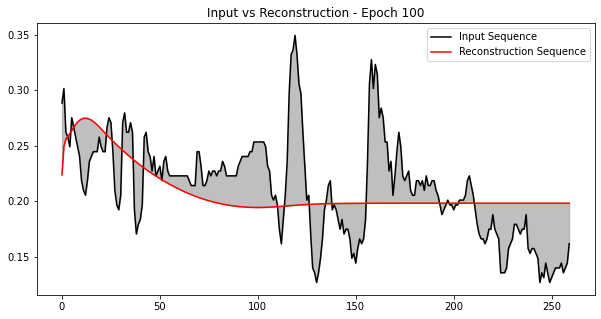

Epoch 101: train loss 13.48942076739143 val loss 13.397034847035128
Epoch 102: train loss 13.724141328475055 val loss 14.432281334259931
Epoch 103: train loss 14.459417943393483 val loss 14.644465698915369
Epoch 104: train loss 14.493395698771756 val loss 14.069361552070168
Epoch 105: train loss 13.875266333187328 val loss 13.548303564857035
Epoch 106: train loss 13.53174768335679 val loss 13.401203559426701
Epoch 107: train loss 13.43612132913926 val loss 13.362503747379078
Epoch 108: train loss 13.476203379911535 val loss 13.484385036019718
Epoch 109: train loss 13.54632718703326 val loss 13.377347048591165
Epoch 110: train loss 13.573432933582978 val loss 13.69312417086433
Epoch 111: train loss 13.774154865040499 val loss 13.604168252383962
Epoch 112: train loss 13.467069900737089 val loss 13.354719358332018
Epoch 113: train loss 13.50102610868566 val loss 13.413425726049086
Epoch 114: train loss 13.489862268111285 val loss 13.327118772618912
Epoch 115: train loss 13.38436071732465 

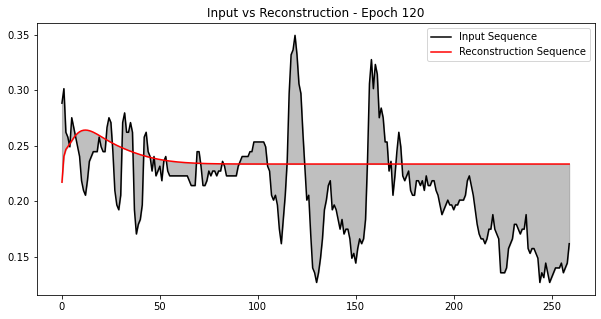

Epoch 121: train loss 13.796146858439727 val loss 13.509534852644977
Epoch 122: train loss 13.647178274042465 val loss 13.480697424271527
Epoch 123: train loss 13.601950084461885 val loss 13.471423278135411
Epoch 124: train loss 13.590257812948789 val loss 13.442891996047075
Epoch 125: train loss 13.591467677845674 val loss 13.564967632293701
Epoch 126: train loss 13.634262713264016 val loss 13.46135254467235
Epoch 127: train loss 13.618935197942397 val loss 13.637350878996008
Epoch 128: train loss 13.871661954767564 val loss 13.468132759543026
Epoch 129: train loss 13.683082597395954 val loss 13.561426274916705
Epoch 130: train loss 14.005795417112463 val loss 13.874350918040555
Epoch 131: train loss 13.832121091730455 val loss 13.425870115616743
Epoch 132: train loss 13.720397803362678 val loss 13.64531629225787
Epoch 133: train loss 13.788976512235754 val loss 13.565667472166174
Epoch 134: train loss 13.703259008071003 val loss 13.563246098686667
Epoch 135: train loss 13.61462645250

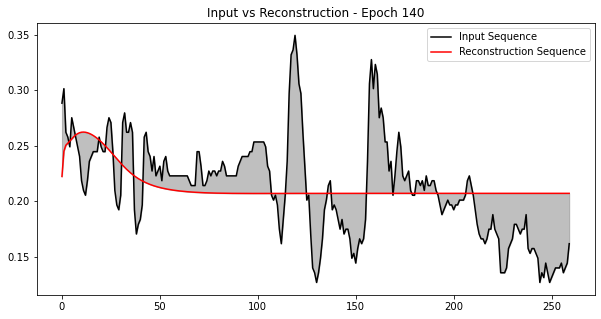

Epoch 141: train loss 13.569044259015252 val loss 13.672925904217887
Epoch 142: train loss 14.474861234777114 val loss 14.492761830722584
Epoch 143: train loss 14.234687676149257 val loss 14.213048009311452
Epoch 144: train loss 14.64011682622573 val loss 15.648713414809283
Epoch 145: train loss 14.411794297835407 val loss 13.910398808647605
Epoch 146: train loss 13.982509685965145 val loss 13.884867881326114
Epoch 147: train loss 13.925377307218664 val loss 13.688412498025333
Epoch 148: train loss 13.831274958217845 val loss 13.713203497493968
Epoch 149: train loss 13.738117554608513 val loss 13.598876891416662
Epoch 150: train loss 13.652642996170941 val loss 13.729671461441937
Epoch 151: train loss 13.667182714798871 val loss 13.63240659938139
Epoch 152: train loss 13.691699415094712 val loss 13.490462291941924
Epoch 153: train loss 13.624453914866727 val loss 13.49240389992209
Epoch 154: train loss 13.705721378326416 val loss 13.405585530224968
Epoch 155: train loss 13.534546947479

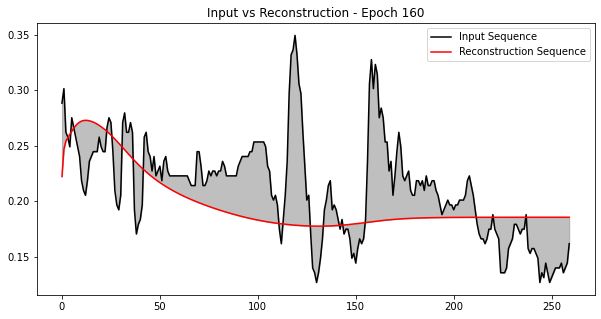

Epoch 161: train loss 13.441941609102138 val loss 13.367193502538344
Epoch 162: train loss 13.399480578478645 val loss 13.32118007996503
Epoch 163: train loss 13.39188264398014 val loss 13.573738025216496
Epoch 164: train loss 13.449524570913876 val loss 13.320916327308206
Epoch 165: train loss 13.461689416099997 val loss 13.407475308810964
Epoch 166: train loss 13.508773349313175 val loss 13.49623690212474
Epoch 167: train loss 13.929202197579777 val loss 14.455543832217947
Epoch 168: train loss 13.947881726657643 val loss 14.23548978917739
Epoch 169: train loss 13.966000102548039 val loss 13.635985778359807
Epoch 170: train loss 13.681008989670698 val loss 13.619460986642277
Epoch 171: train loss 13.732211831036736 val loss 13.83830010470222
Epoch 172: train loss 13.70881367851706 val loss 13.86541171354406
Epoch 173: train loss 13.850584832359763 val loss 14.175500061932732
Epoch 174: train loss 13.79172649383545 val loss 13.639429339240579
Epoch 175: train loss 13.780254257426542 v

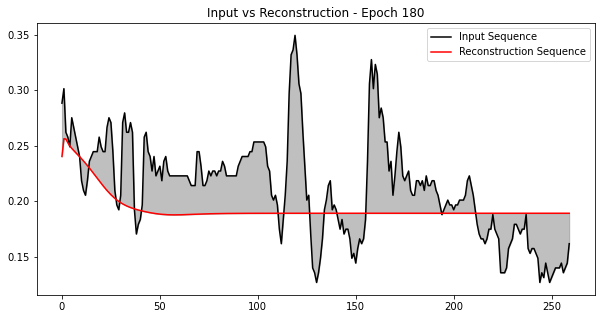

Epoch 181: train loss 13.741175191542682 val loss 13.785073975955738
Epoch 182: train loss 13.716357444314395 val loss 13.8844822659212
Epoch 183: train loss 13.729340261571547 val loss 13.60867240008186
Epoch 184: train loss 13.706282722248751 val loss 13.658654336368336
Epoch 185: train loss 13.65282907485962 val loss 13.790489802641027
Epoch 186: train loss 13.781745416977826 val loss 13.703758082670324
Epoch 187: train loss 13.701260258169736 val loss 13.929266318152932
Epoch 188: train loss 13.756630246779498 val loss 13.85234313291662
Epoch 189: train loss 13.743816386952119 val loss 13.747194587483126
Epoch 190: train loss 13.663246895285214 val loss 13.569588324602913
Epoch 191: train loss 13.568402301563935 val loss 13.537898658303654
Epoch 192: train loss 13.675910394331988 val loss 13.507687114266789
Epoch 193: train loss 13.646694587258732 val loss 13.761252706191119
Epoch 194: train loss 13.749550286461325 val loss 14.56267833148732
Epoch 195: train loss 13.763275763567757

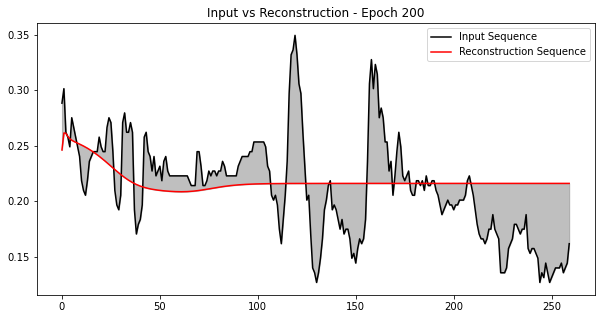

Epoch 201: train loss 13.746624750249525 val loss 14.409591125039494
Epoch 202: train loss 13.701735614327823 val loss 13.611673209246467
Epoch 203: train loss 13.606716660892262 val loss 14.27982738719267
Epoch 204: train loss 13.660913540335262 val loss 14.252854476255528
Epoch 205: train loss 14.007446990293616 val loss 14.124946425942813
Epoch 206: train loss 13.937838128033807 val loss 15.12462931801291
Epoch 207: train loss 13.737311772739186 val loss 13.93869711932014
Epoch 208: train loss 13.529352810803582 val loss 13.606631234112907
Epoch 209: train loss 13.955828346925623 val loss 15.652043118196374
Epoch 210: train loss 15.838897907032687 val loss 15.546286162208109
Epoch 211: train loss 14.04009293387918 val loss 13.730721081004424
Epoch 212: train loss 13.749089745914235 val loss 13.626247434055104
Epoch 213: train loss 13.930795882729923 val loss 13.607061470256133
Epoch 214: train loss 13.687961881300982 val loss 13.584086384492762
Epoch 215: train loss 14.0117513937108

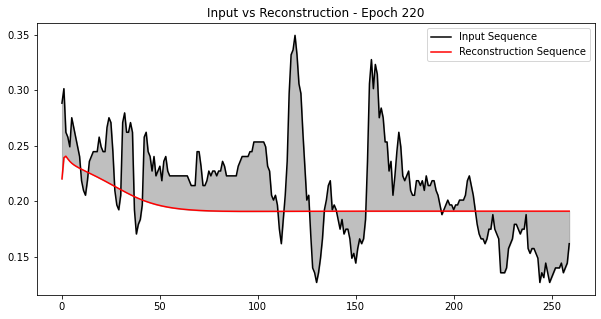

Epoch 221: train loss 13.704676706650678 val loss 13.590354852115407
Epoch 222: train loss 13.720192314596737 val loss 13.585251017177805
Epoch 223: train loss 13.948520879184498 val loss 13.642140775568345
Epoch 224: train loss 13.79381389056935 val loss 13.599869139054242
Epoch 225: train loss 13.67963919359095 val loss 13.51470573088702
Epoch 226: train loss 13.592116860782399 val loss 13.487544609518611
Epoch 227: train loss 14.381460346895105 val loss 13.877370424831614
Epoch 228: train loss 13.769707819994759 val loss 13.587822005328011
Epoch 229: train loss 13.769930059769575 val loss 13.624008515301872
Epoch 230: train loss 13.66269578372731 val loss 13.534158005433923
Epoch 231: train loss 13.721615937176873 val loss 13.552692963095271
Epoch 232: train loss 13.62323969111723 val loss 13.528175157659193
Epoch 233: train loss 13.630677621504839 val loss 13.545411429685705
Epoch 234: train loss 13.651563156352324 val loss 13.59692861332613
Epoch 235: train loss 13.59699281243717 

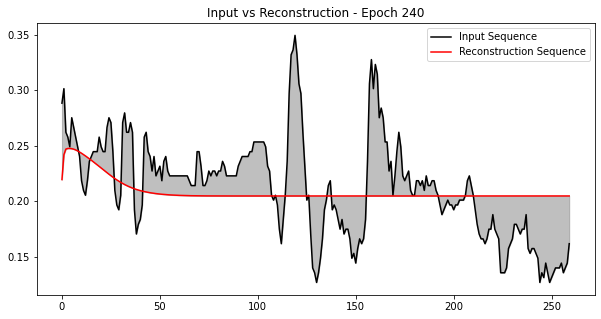

Epoch 241: train loss 13.534797062593348 val loss 13.471726563397576
Epoch 242: train loss 13.531526391646441 val loss 13.451165008544923
Epoch 243: train loss 13.55400250939762 val loss 13.402552273694207
Epoch 244: train loss 13.816634834513945 val loss 13.784245979084687
Epoch 245: train loss 13.740582903693705 val loss 13.548508038240321
Epoch 246: train loss 13.684520166060503 val loss 13.557208352930406
Epoch 247: train loss 13.801637066111844 val loss 14.458203528909122
Epoch 248: train loss 13.892771288927865 val loss 14.075616393369787
Epoch 249: train loss 13.890110717100256 val loss 14.323599147796632
Epoch 250: train loss 13.740210263869342 val loss 13.96146765316234
Epoch 251: train loss 13.673283380620619 val loss 14.068823017793543
Epoch 252: train loss 13.80831133337582 val loss 13.735581089468564
Epoch 253: train loss 13.639318729849423 val loss 13.692203050501206
Epoch 254: train loss 13.616873516755945 val loss 13.606062911538517
Epoch 255: train loss 13.568253034703

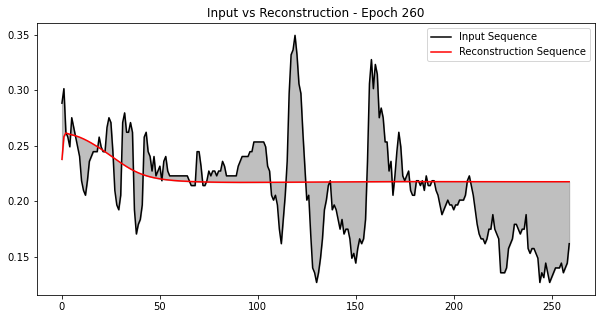

Epoch 261: train loss 13.560998394910026 val loss 13.622888890434714
Epoch 262: train loss 13.541962118709788 val loss 13.6915797514074
Epoch 263: train loss 13.627485752105713 val loss 13.664291505252613
Epoch 264: train loss 13.528947151408476 val loss 13.344006858152502
Epoch 265: train loss 13.59424379012164 val loss 13.823600022933062
Epoch 266: train loss 13.722118192560533 val loss 13.457365142597872
Epoch 267: train loss 13.599828383501839 val loss 13.637657485288733
Epoch 268: train loss 13.638222441953772 val loss 13.342961361828973
Epoch 269: train loss 13.557613468170166 val loss 13.39461379331701
Epoch 270: train loss 13.846030678468592 val loss 13.906494314530317
Epoch 271: train loss 13.74874334896312 val loss 13.398906999475816
Epoch 272: train loss 14.086064966987161 val loss 13.619757068858426
Epoch 273: train loss 13.856539726257324 val loss 13.658077901952407
Epoch 274: train loss 13.788839788997874 val loss 13.855740917430204
Epoch 275: train loss 14.80650669546688

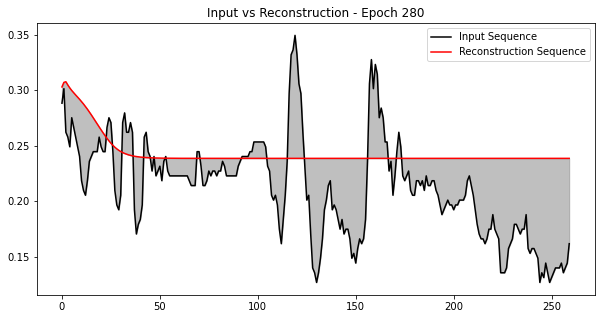

Epoch 281: train loss 14.512804440891042 val loss 14.443384451024672
Epoch 282: train loss 14.007202120388255 val loss 13.526034181258257
Saving best model
Epoch 283: train loss 13.533646667704863 val loss 13.281610544990091
Epoch 284: train loss 13.898094014560476 val loss 13.947899537927965
Epoch 285: train loss 13.633475208282471 val loss 13.90766196531408
Epoch 286: train loss 13.471948803172392 val loss 13.323341582803165
Epoch 287: train loss 13.63840264152078 val loss 13.385762635399313
Epoch 288: train loss 13.843343566445743 val loss 13.70404037587783
Epoch 289: train loss 13.448800350637997 val loss 13.438401295157039
Epoch 290: train loss 13.430889174517464 val loss 13.522856061598834
Saving best model
Epoch 291: train loss 13.457084055507885 val loss 13.276246020373176
Epoch 292: train loss 13.454492198719699 val loss 13.43547965218039
Saving best model
Epoch 293: train loss 13.491548066980698 val loss 13.22915148454554
Epoch 294: train loss 13.586383741042193 val loss 13.3

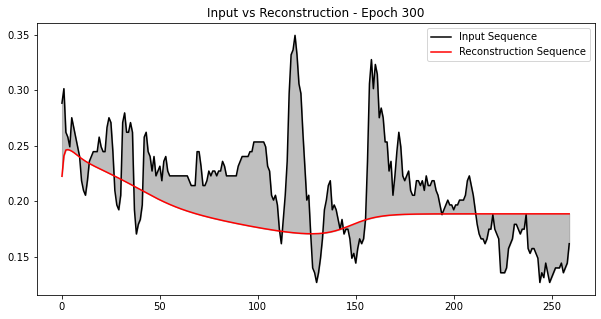

Epoch 301: train loss 14.001987586301915 val loss 13.930585737789379
Epoch 302: train loss 13.384763167886174 val loss 13.426637290505802
Epoch 303: train loss 13.702555207645192 val loss 13.300724826139563
Epoch 304: train loss 13.416980631211224 val loss 13.414065686394187
Epoch 305: train loss 13.311443895452163 val loss 13.638404840581558
Epoch 306: train loss 13.769981939652387 val loss 13.423885154724122
Epoch 307: train loss 13.51420955657959 val loss 13.799168474533978
Epoch 308: train loss 13.617577132056741 val loss 13.478095811956068
Epoch 309: train loss 13.563517278783461 val loss 13.268532949335436
Epoch 310: train loss 13.952467694002038 val loss 14.254296342064352
Epoch 311: train loss 14.033767077502082 val loss 13.548317078983082
Epoch 312: train loss 13.323493205799776 val loss 13.671870916029986
Epoch 313: train loss 13.523365441490622 val loss 13.342228721169864
Epoch 314: train loss 13.853148796979118 val loss 13.696046711416805
Epoch 315: train loss 13.5860707002

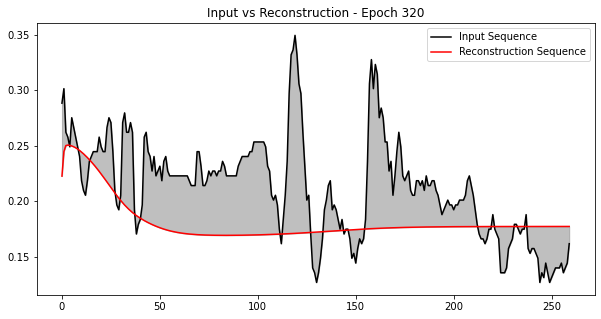

Epoch 321: train loss 13.755087818818934 val loss 13.500746586743523
Epoch 322: train loss 13.602927623075598 val loss 13.468949132807115
Saving best model
Epoch 323: train loss 13.454698450425091 val loss 13.223391044841094
Epoch 324: train loss 13.493079740860884 val loss 13.527741050720214
Epoch 325: train loss 13.29355562434477 val loss 13.748686863394344
Epoch 326: train loss 13.604723986457376 val loss 13.53224869335399
Epoch 327: train loss 13.449776610206156 val loss 13.296170021505917
Epoch 328: train loss 13.553252814797794 val loss 13.695249316271614
Epoch 329: train loss 13.767741764292998 val loss 13.616929099139046
Epoch 330: train loss 13.723642237046185 val loss 13.69908322726979
Epoch 331: train loss 13.877293093064251 val loss 13.3485619096195
Epoch 332: train loss 13.307199584736544 val loss 13.325594587887034
Epoch 333: train loss 13.347379499323228 val loss 13.49320458243875
Epoch 334: train loss 14.725808895335478 val loss 14.191013145446778
Epoch 335: train loss 

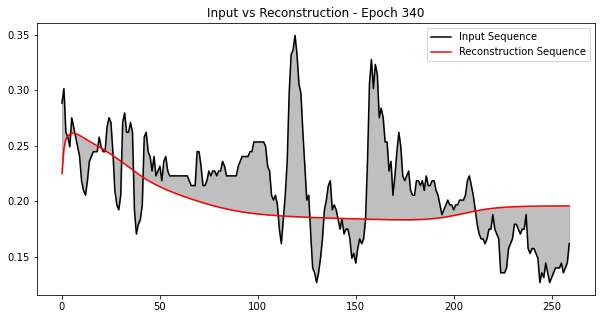

Epoch 341: train loss 13.500082930396585 val loss 13.654705126145307
Epoch 342: train loss 13.475496724072624 val loss 13.347944551355699
Epoch 343: train loss 13.595304926703959 val loss 13.2965830634622
Epoch 344: train loss 13.348903577467974 val loss 13.668852929507985
Epoch 345: train loss 13.508092852199779 val loss 13.531318266251509
Epoch 346: train loss 13.854946630141315 val loss 13.963532419765697
Epoch 347: train loss 13.663355496350457 val loss 13.61655584784115
Epoch 348: train loss 14.328501852820901 val loss 13.821368570888744
Epoch 349: train loss 13.672728319729076 val loss 14.252589831632726
Epoch 350: train loss 14.27819658167222 val loss 13.776124398848589
Epoch 351: train loss 13.533850765228271 val loss 13.659310262343462
Epoch 352: train loss 13.74170561397777 val loss 13.386570801454432
Epoch 353: train loss 13.74514300402473 val loss 13.721729901257683
Epoch 354: train loss 13.8788039263557 val loss 13.67522533080157
Epoch 355: train loss 13.669734444337733 va

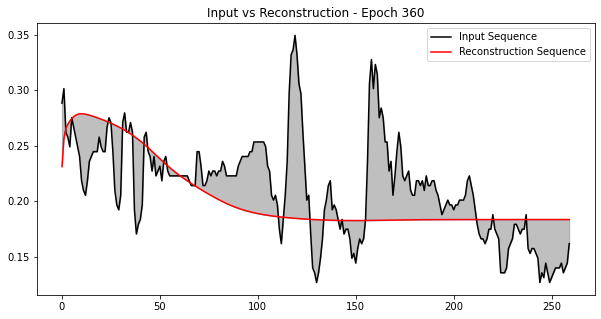

Epoch 361: train loss 13.398526343177346 val loss 13.229385235730339
Epoch 362: train loss 13.48469877243042 val loss 13.78123576220344
Epoch 363: train loss 13.544961463703828 val loss 13.577173362058751
Epoch 364: train loss 13.636933063058292 val loss 13.65472869873047
Epoch 365: train loss 13.528171668333165 val loss 13.229379911983715
Epoch 366: train loss 13.36832369075102 val loss 13.25608637753655
Epoch 367: train loss 13.439161031386432 val loss 13.22704403260175
Epoch 368: train loss 14.0844295501709 val loss 13.886881351470947
Epoch 369: train loss 13.53402135512408 val loss 13.635605772803812
Epoch 370: train loss 13.87758036220775 val loss 13.852723531162038
Epoch 371: train loss 13.698919834810145 val loss 13.640026945226333
Epoch 372: train loss 13.358243212980383 val loss 13.926127675000359
Epoch 373: train loss 13.592939029020421 val loss 13.873499718834372
Epoch 374: train loss 13.904350836136762 val loss 13.883901826073142
Saving best model
Epoch 375: train loss 13.3

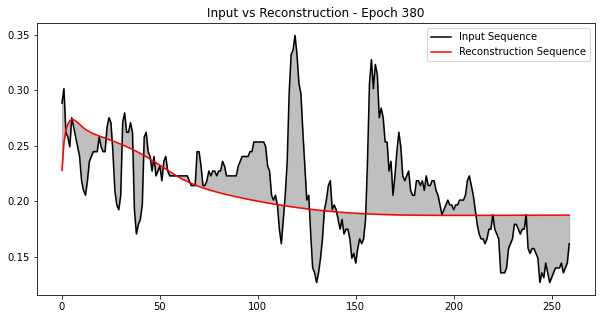

Epoch 381: train loss 13.559543934990378 val loss 13.495993513219497
Saving best model
Epoch 382: train loss 13.303746442233814 val loss 13.041212979485007
Epoch 383: train loss 13.162807105569279 val loss 13.08788989010979
Epoch 384: train loss 13.719162997077493 val loss 13.918356390560374
Epoch 385: train loss 14.090934545853559 val loss 14.587792772405288
Epoch 386: train loss 13.875300368140726 val loss 13.874669490141027
Epoch 387: train loss 13.771655817592846 val loss 13.885772755566766
Epoch 388: train loss 13.703430046754725 val loss 13.77786807452931
Epoch 389: train loss 13.550099877750172 val loss 13.124664738598991
Epoch 390: train loss 14.060615763944739 val loss 15.95974775763119
Epoch 391: train loss 14.994526330162497 val loss 14.569536450329949
Epoch 392: train loss 14.204437469033634 val loss 13.882861513250015
Epoch 393: train loss 15.352145441840676 val loss 16.409896199843462
Epoch 394: train loss 15.722375892190373 val loss 14.65470495223999
Epoch 395: train los

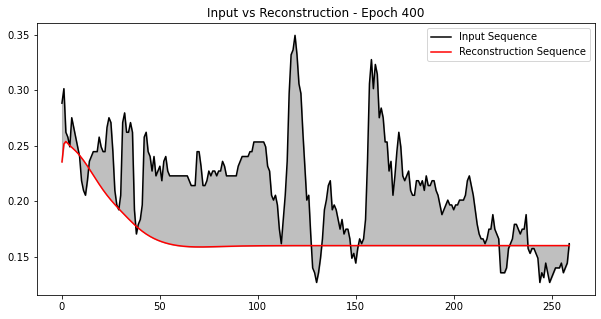

Epoch 401: train loss 13.589956642599667 val loss 13.365166776320514
Epoch 402: train loss 13.62662456736845 val loss 13.875404301811667
Epoch 403: train loss 13.719133590249454 val loss 13.632880177217372
Epoch 404: train loss 13.496319069581872 val loss 13.819302292431102
Epoch 405: train loss 14.242624024783863 val loss 14.426198308608111
Epoch 406: train loss 14.19589028077967 val loss 13.79512082829195
Epoch 407: train loss 14.48054957670324 val loss 14.074889800127815
Epoch 408: train loss 14.041845220677994 val loss 13.732000844618854
Epoch 409: train loss 14.019907331466674 val loss 13.899200164570528
Epoch 410: train loss 13.963130704094382 val loss 13.729489758435417
Epoch 411: train loss 13.848294381534352 val loss 13.64862958683687
Epoch 412: train loss 13.754475436491125 val loss 13.60533364800846
Epoch 413: train loss 14.209301780251895 val loss 13.89158374561983
Epoch 414: train loss 13.950812132218305 val loss 14.108587478188907
Epoch 415: train loss 13.789357903424431 

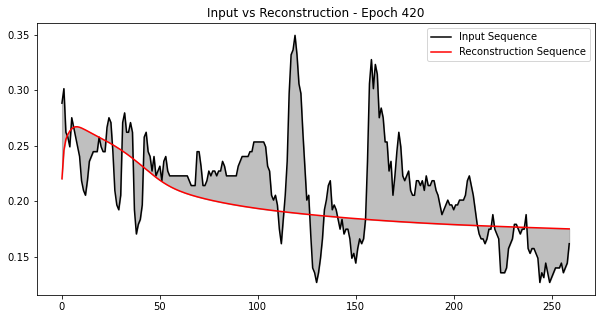

Epoch 421: train loss 13.599128768023323 val loss 13.447458457946777
Epoch 422: train loss 13.849971255134134 val loss 13.881784018348245
Epoch 423: train loss 14.232240317849552 val loss 13.594185397204232
Epoch 424: train loss 13.746785752913532 val loss 13.523403296751134
Epoch 425: train loss 13.604365040274228 val loss 13.504437368056353
Epoch 426: train loss 13.663429378060734 val loss 13.503698270461138
Epoch 427: train loss 13.513716579886044 val loss 13.558244800567627
Epoch 428: train loss 13.862825842464671 val loss 14.229651333304012
Epoch 429: train loss 13.692850763657514 val loss 13.376426792144775
Epoch 430: train loss 13.482708128760843 val loss 13.41960921568029
Epoch 431: train loss 13.435976589427275 val loss 13.312983855079201
Epoch 432: train loss 13.62619961009306 val loss 13.946747190812054
Epoch 433: train loss 13.67061019224279 val loss 13.255856480317957
Epoch 434: train loss 13.49868517482982 val loss 13.236872880599078
Epoch 435: train loss 13.4394738590016

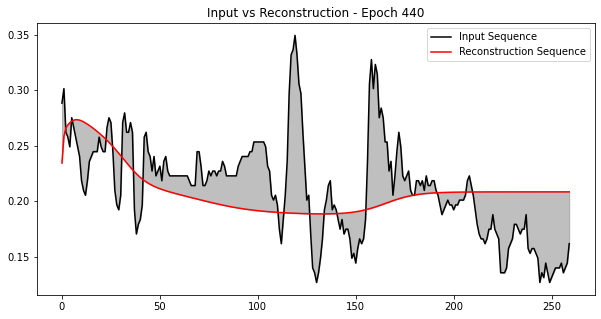

Epoch 441: train loss 13.797350215911866 val loss 13.529009392682244
Epoch 442: train loss 13.563622867359834 val loss 13.733188550612505
Epoch 443: train loss 13.443895306306727 val loss 13.418487111259909
Epoch 444: train loss 13.547976970672607 val loss 13.943676527808694
Epoch 445: train loss 13.499806886560776 val loss 13.434307513517492
Epoch 446: train loss 13.922757204841165 val loss 14.062759736004997
Epoch 447: train loss 13.388178483177635 val loss 13.547419155345244
Epoch 448: train loss 13.508766028460334 val loss 13.3433962541468
Epoch 449: train loss 13.416679780623491 val loss 13.911332859712488
Epoch 450: train loss 13.83812494277954 val loss 13.968831325979794
Epoch 451: train loss 13.856851140190573 val loss 13.807406874263988
Epoch 452: train loss 13.293705227795769 val loss 13.755221462249756
Epoch 453: train loss 13.628603912802303 val loss 14.376757172977223
Epoch 454: train loss 13.484523733924417 val loss 13.392427113476922
Epoch 455: train loss 14.215614806904

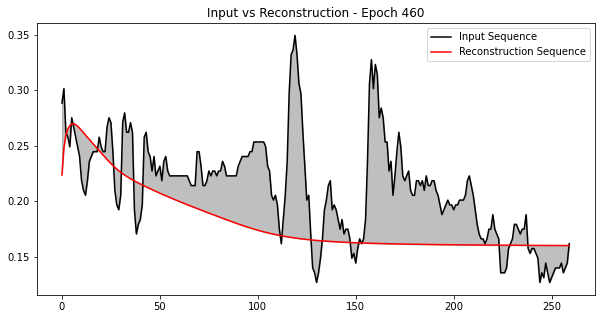

Epoch 461: train loss 13.535751707413617 val loss 13.50592368630802
Epoch 462: train loss 13.321592482398538 val loss 13.62942148657406
Epoch 463: train loss 13.821149410920984 val loss 14.159532748951632
Epoch 464: train loss 13.613657048169305 val loss 13.345908467909869
Epoch 465: train loss 13.592771945280187 val loss 13.105096211152919
Epoch 466: train loss 13.960951670478371 val loss 14.190886637743782
Epoch 467: train loss 13.681858988369212 val loss 13.920375633239747
Epoch 468: train loss 13.666332239263198 val loss 13.050014086330638
Epoch 469: train loss 13.18146705346949 val loss 13.267612575082218
Saving best model
Epoch 470: train loss 13.20079969518325 val loss 12.993785813275505
Epoch 471: train loss 13.147916928459617 val loss 13.738147157781265
Epoch 472: train loss 13.654276009166942 val loss 13.223723607904772
Epoch 473: train loss 13.231685543060303 val loss 14.298575059105369
Epoch 474: train loss 13.915027018154369 val loss 15.019097698436063
Epoch 475: train los

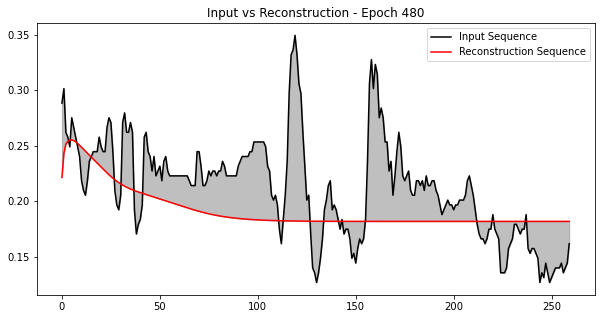

Epoch 481: train loss 14.160271908255185 val loss 13.646286925147562
Epoch 482: train loss 13.760254540162927 val loss 13.76389383989222
Epoch 483: train loss 13.618719990113203 val loss 13.293501071368947
Epoch 484: train loss 13.453742574242984 val loss 13.295821582569795
Epoch 485: train loss 13.279858510634478 val loss 13.535094704347499
Epoch 486: train loss 13.49113015567555 val loss 13.335385288911707
Epoch 487: train loss 13.195905289930456 val loss 13.305915714712704
Epoch 488: train loss 13.262919249254114 val loss 13.05984447703642
Epoch 489: train loss 13.222258783789242 val loss 13.066231391009163
Epoch 490: train loss 13.224857835208669 val loss 13.266684627532959
Epoch 491: train loss 13.250763531292186 val loss 13.268141853108126
Epoch 492: train loss 13.210129962247962 val loss 13.41761558196124
Epoch 493: train loss 13.41159480599796 val loss 13.356915350521312
Epoch 494: train loss 13.505887163386625 val loss 13.456952583088594
Epoch 495: train loss 13.39160708820118

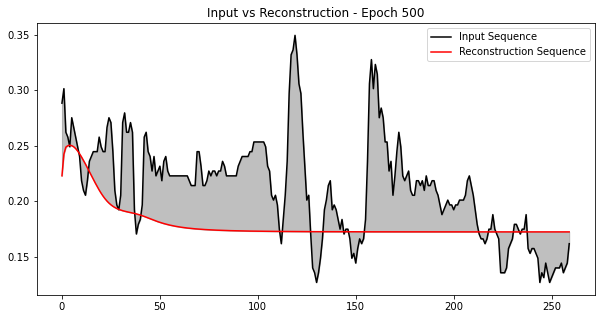

Epoch 501: train loss 13.665834729811724 val loss 13.51840804043938
Epoch 502: train loss 13.59136271757238 val loss 13.506712627410888
Epoch 503: train loss 13.446724229700425 val loss 13.498978076261633
Epoch 504: train loss 13.427649110906264 val loss 13.152091031916001
Epoch 505: train loss 13.649816131591797 val loss 13.69070988262401
Epoch 506: train loss 13.422466766133027 val loss 13.09923740274766
Epoch 507: train loss 13.787801630356732 val loss 13.784883218653063
Epoch 508: train loss 14.24447530297672 val loss 13.704661969577565
Epoch 509: train loss 13.680715605791878 val loss 13.479555090735941
Epoch 510: train loss 13.812958229289336 val loss 13.454263608595904
Epoch 511: train loss 13.579628815370448 val loss 13.54235886966481
Epoch 512: train loss 13.593423338497386 val loss 13.671732324712417
Epoch 513: train loss 14.098442077636719 val loss 16.03815444497501
Epoch 514: train loss 14.79699099484612 val loss 13.757860228594613
Epoch 515: train loss 13.536937197516947 v

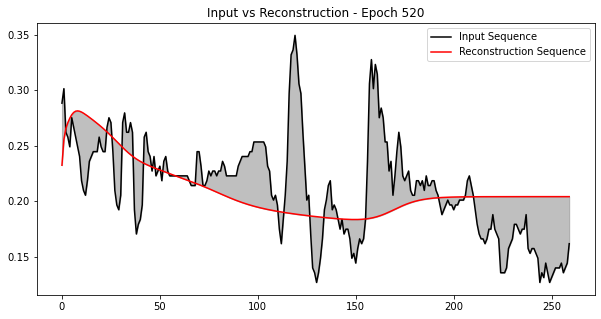

Epoch 521: train loss 13.61238759545719 val loss 13.782249663857852
Epoch 522: train loss 13.402679420919979 val loss 13.660445084291347
Epoch 523: train loss 13.609430127985338 val loss 13.536037854587331
Epoch 524: train loss 13.503640169255874 val loss 13.294581862056956
Epoch 525: train loss 13.515132079404943 val loss 13.723811441309312
Epoch 526: train loss 13.457684258853687 val loss 13.143424471686869
Epoch 527: train loss 13.19893050474279 val loss 13.210808215421789
Epoch 528: train loss 13.119197149837719 val loss 13.665312839956844
Epoch 529: train loss 14.213256594713997 val loss 13.742998729032628
Epoch 530: train loss 13.976004729551427 val loss 13.587139623305378
Epoch 531: train loss 13.675958380979651 val loss 13.869611784991097
Epoch 532: train loss 13.57152770547306 val loss 13.31955919265747
Epoch 533: train loss 13.628686916126924 val loss 14.051192306069767
Epoch 534: train loss 13.853355912601247 val loss 13.93831277735093
Epoch 535: train loss 13.57549007079180

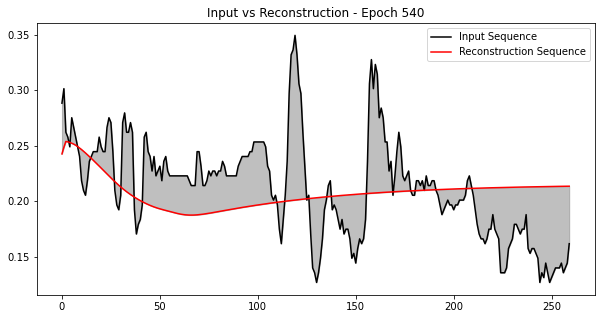

Epoch 541: train loss 14.241461125542136 val loss 13.525272593778723
Epoch 542: train loss 13.76266238268684 val loss 13.348564411612118
Epoch 543: train loss 13.63557139003978 val loss 13.981822883381563
Epoch 544: train loss 14.02845090417301 val loss 13.549867557076848
Epoch 545: train loss 14.523026157827939 val loss 14.711540710224824
Epoch 546: train loss 13.564590325075038 val loss 13.26742109410903
Epoch 547: train loss 13.359222456988167 val loss 13.189024347417496
Epoch 548: train loss 13.258659351573272 val loss 13.431300763522877
Epoch 549: train loss 13.337402820587158 val loss 13.184683698766372
Epoch 550: train loss 13.585052680969238 val loss 13.903442506229176
Epoch 551: train loss 13.540521099988151 val loss 13.181760521496043
Epoch 552: train loss 13.265349820080925 val loss 13.234401674831615
Epoch 553: train loss 13.76534289191751 val loss 13.918484202553245
Epoch 554: train loss 13.502867064756506 val loss 13.122530547310324
Epoch 555: train loss 13.07574274399701

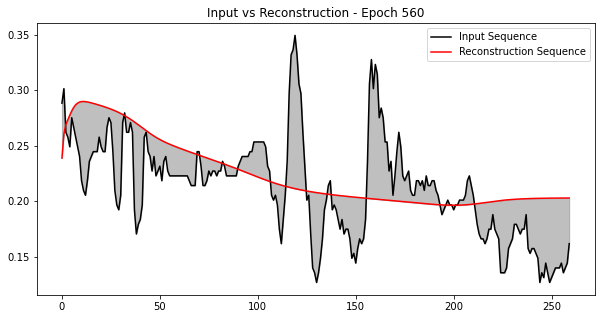

Epoch 561: train loss 13.174231719970702 val loss 13.208606877046472
Epoch 562: train loss 13.364661284054026 val loss 13.065377285901238
Epoch 563: train loss 13.278669458277085 val loss 13.104712340411018
Epoch 564: train loss 13.180568291159236 val loss 13.196884273080265
Epoch 565: train loss 13.613178056829115 val loss 13.631856385399313
Epoch 566: train loss 13.459029096715591 val loss 13.27514892465928
Epoch 567: train loss 14.159471713795382 val loss 13.678905599257526
Epoch 568: train loss 13.896896367914536 val loss 13.83503236209645
Epoch 569: train loss 13.634667312397676 val loss 14.749672710194307
Epoch 570: train loss 13.935727725309484 val loss 13.869868239234476
Epoch 571: train loss 13.776501094593721 val loss 13.667743974573472
Epoch 572: train loss 13.916505695791805 val loss 14.577231710097369
Epoch 573: train loss 14.549522411122041 val loss 13.94810104931102
Epoch 574: train loss 13.924184041864732 val loss 13.74896967270795
Epoch 575: train loss 14.6206261803122

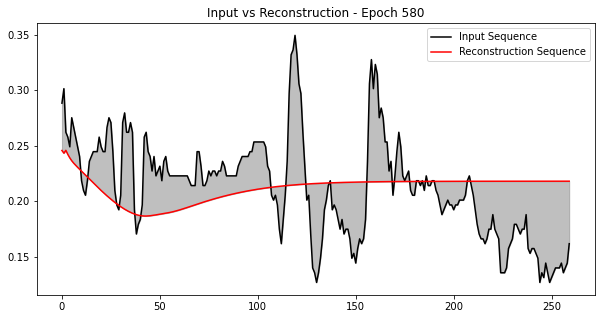

Epoch 581: train loss 14.000500611697927 val loss 13.824641519434312
Epoch 582: train loss 14.002073646994198 val loss 14.030806008507223
Epoch 583: train loss 14.077634822621064 val loss 14.053791758593391
Epoch 584: train loss 14.033019200493309 val loss 15.765888455334832
Epoch 585: train loss 14.93730562434477 val loss 14.291478431926054
Epoch 586: train loss 14.47069668489344 val loss 14.969557044085334
Epoch 587: train loss 14.579049884571749 val loss 15.247739926506492
Epoch 588: train loss 14.411146511751063 val loss 14.869563220528995
Epoch 589: train loss 14.442947334401747 val loss 14.161112807778752
Epoch 590: train loss 14.093459255555096 val loss 14.554023212545058
Epoch 591: train loss 13.925018512501437 val loss 13.859841840407428
Epoch 592: train loss 13.707802346173455 val loss 13.89842316122616
Epoch 593: train loss 13.711446375005385 val loss 13.734638331918156
Epoch 594: train loss 13.599305158502915 val loss 13.581175764869242
Epoch 595: train loss 13.900327867620

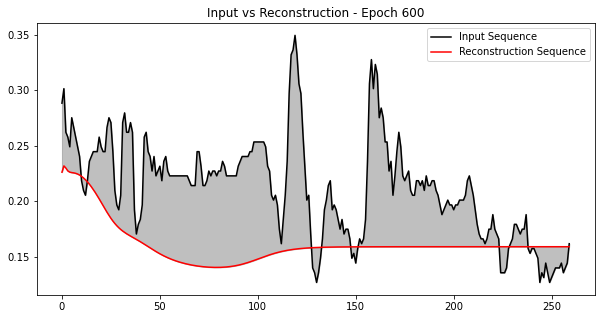

Epoch 601: train loss 14.84504425946404 val loss 13.711335263532751
Epoch 602: train loss 15.268690501942354 val loss 15.155601622076595
Epoch 603: train loss 14.2380182799171 val loss 14.33730125988231
Epoch 604: train loss 13.869592262716854 val loss 13.888516033397002
Epoch 605: train loss 15.281682822283576 val loss 13.879512573690976
Epoch 606: train loss 13.701350683324478 val loss 13.546688192030963
Epoch 607: train loss 13.679116024690515 val loss 13.62799970963422
Epoch 608: train loss 13.616384147195255 val loss 13.55366112765144
Epoch 609: train loss 13.598881025875317 val loss 13.582133197784424
Epoch 610: train loss 13.61413750368006 val loss 13.597485278634464
Epoch 611: train loss 13.61573922774371 val loss 13.62246976179235
Epoch 612: train loss 13.627366784039666 val loss 14.122065549738267
Epoch 613: train loss 13.635939710280475 val loss 13.65840934865615
Epoch 614: train loss 13.592603459077722 val loss 13.474232168758617
Epoch 615: train loss 13.561927767360912 val

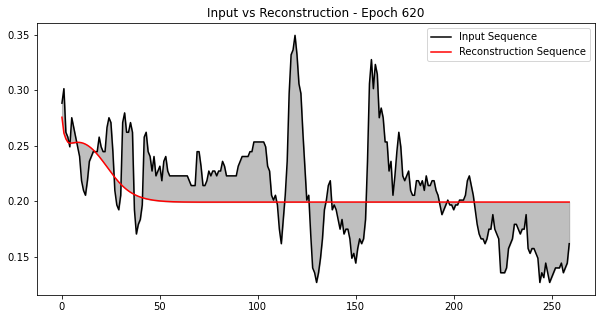

Epoch 621: train loss 13.600581331814036 val loss 13.521454076205982
Epoch 622: train loss 13.584144794239718 val loss 13.50568832509658
Epoch 623: train loss 13.602098453746123 val loss 13.467192358129164
Epoch 624: train loss 13.576552548128015 val loss 13.538053585501277
Epoch 625: train loss 13.622529832054587 val loss 13.522770404815674
Epoch 626: train loss 13.576811857784495 val loss 13.510360723383286
Epoch 627: train loss 13.613387203216552 val loss 13.506950552323286
Epoch 628: train loss 13.614696485856 val loss 13.612307986091166
Epoch 629: train loss 13.638492443982292 val loss 13.472014561821434
Epoch 630: train loss 13.489903096591725 val loss 13.765741984984453
Epoch 631: train loss 13.489464064205395 val loss 13.49713545406566
Epoch 632: train loss 13.829721966911764 val loss 13.866831706551945
Epoch 633: train loss 13.630188709146836 val loss 13.700605016596176
Epoch 634: train loss 13.575866828245275 val loss 13.350900262944839
Epoch 635: train loss 13.66761723125682

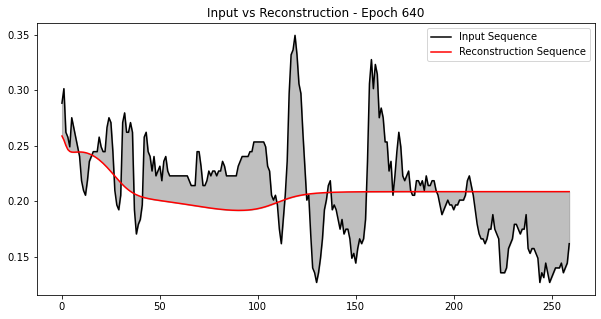

Epoch 641: train loss 13.381168141084558 val loss 13.228818879407996
Epoch 642: train loss 13.369479269139907 val loss 13.402842022390926
Epoch 643: train loss 13.793156309688792 val loss 13.691662367652444
Epoch 644: train loss 13.385219085917754 val loss 14.1723765261033
Epoch 645: train loss 15.533591808992274 val loss 14.843915922501507
Epoch 646: train loss 14.782982607448803 val loss 14.3067985422471
Epoch 647: train loss 14.088692463145536 val loss 14.431655782811783
Epoch 648: train loss 13.928869713053984 val loss 13.900246928719913
Epoch 649: train loss 14.106035866456873 val loss 13.806761977251838
Epoch 650: train loss 14.022179558697868 val loss 14.158376317865708
Epoch 651: train loss 14.28438414966359 val loss 14.478092653611126
Epoch 652: train loss 14.614149525586296 val loss 14.496503723368924
Epoch 653: train loss 14.287811486861285 val loss 13.946362731036018
Epoch 654: train loss 13.934368644041173 val loss 13.867384495454676
Epoch 655: train loss 13.98958845138549

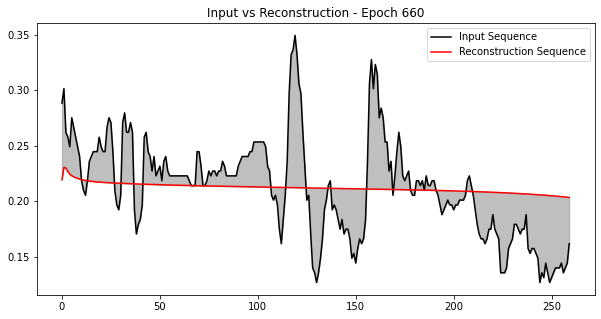

Epoch 661: train loss 13.774660581700942 val loss 13.50487783095416
Epoch 662: train loss 13.7520107830272 val loss 13.69187438067268
Epoch 663: train loss 14.357223897821763 val loss 14.164801103928509
Epoch 664: train loss 14.14574182173785 val loss 13.67016149408677
Epoch 665: train loss 13.787742648405187 val loss 13.423498232224409
Epoch 666: train loss 13.690040756674374 val loss 13.444712004942053
Epoch 667: train loss 13.767530634823967 val loss 13.318432168399587
Epoch 668: train loss 13.454698495303884 val loss 13.233520087073831
Epoch 669: train loss 13.415824115977568 val loss 13.15709446177763
Epoch 670: train loss 13.218396972207461 val loss 13.419750567043529
Epoch 671: train loss 13.736521008435417 val loss 14.002468479380887
Epoch 672: train loss 13.535834660249598 val loss 13.565329130958109
Epoch 673: train loss 13.55146806941313 val loss 14.586179839863497
Epoch 674: train loss 13.8517635233262 val loss 13.586454240013571
Epoch 675: train loss 13.353760781007654 val

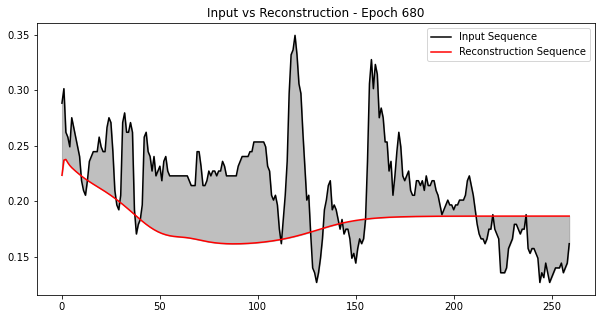

Epoch 681: train loss 13.125316687191233 val loss 13.124129760966582
Epoch 682: train loss 12.925204995099236 val loss 12.941862880482393
Epoch 683: train loss 12.851336978463566 val loss 13.147430795781753
Epoch 684: train loss 13.14874423531925 val loss 13.268762650209315
Epoch 685: train loss 13.299127057019401 val loss 14.114626452502083
Epoch 686: train loss 13.30135596780216 val loss 13.260529383491066
Saving best model
Epoch 687: train loss 13.00594487470739 val loss 12.792044516170726
Epoch 688: train loss 12.843305688745835 val loss 13.185266444262336
Epoch 689: train loss 13.473427564957563 val loss 13.391822343714097
Epoch 690: train loss 13.511691497353947 val loss 13.621199321746825
Saving best model
Epoch 691: train loss 13.28507531670963 val loss 12.788146361182717
Saving best model
Epoch 692: train loss 12.806521309123319 val loss 12.720647733351763
Epoch 693: train loss 13.538071222866282 val loss 12.927420672248392
Epoch 694: train loss 12.866385751612047 val loss 12.

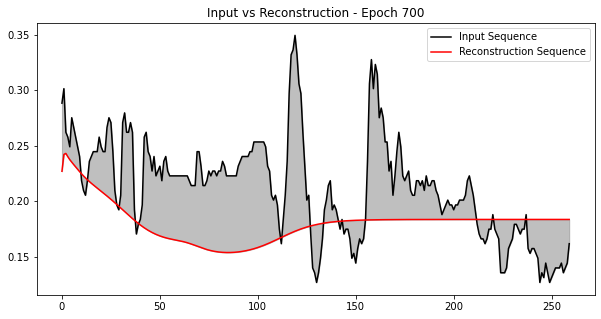

Saving best model
Epoch 701: train loss 12.757957396787756 val loss 12.527869510650635
Epoch 702: train loss 13.171800871456371 val loss 13.118321216807646
Epoch 703: train loss 12.96414826898014 val loss 12.728813070409439
Epoch 704: train loss 13.148730429481057 val loss 12.927780852598303
Epoch 705: train loss 13.013644751380472 val loss 12.844980267917409
Epoch 706: train loss 13.898914802775664 val loss 14.252722392362706
Epoch 707: train loss 13.945811849481919 val loss 13.952799224853516
Epoch 708: train loss 13.756549487394444 val loss 13.744080156438491
Epoch 709: train loss 13.658964819066664 val loss 13.355975308137781
Epoch 710: train loss 14.127742402693805 val loss 13.728499227411607
Epoch 711: train loss 13.6359691844267 val loss 13.210194879419664
Epoch 712: train loss 13.452706858691048 val loss 13.348392346326042
Epoch 713: train loss 13.851153154934154 val loss 13.662867585350485
Epoch 714: train loss 13.587591294681324 val loss 13.37558292501113
Epoch 715: train los

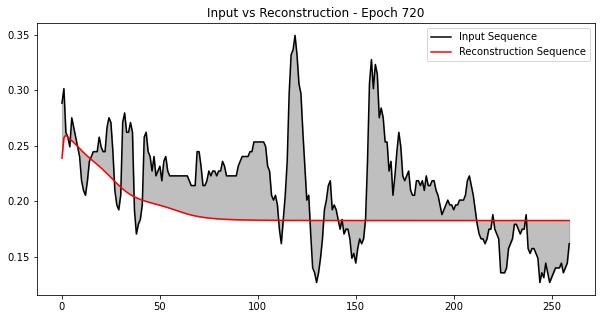

Epoch 721: train loss 13.408029713350183 val loss 13.23721128912533
Epoch 722: train loss 13.323734816382913 val loss 13.315819644927979
Epoch 723: train loss 13.191888405294979 val loss 12.919635004155776
Epoch 724: train loss 13.057886600494385 val loss 12.94715659758624
Epoch 725: train loss 13.667327611586627 val loss 13.450077056884766
Epoch 726: train loss 14.82876635719748 val loss 14.2845625260297
Epoch 727: train loss 13.934003835565903 val loss 13.556647025837618
Epoch 728: train loss 13.5192582803614 val loss 13.595287177141975
Epoch 729: train loss 13.515449568804573 val loss 13.222000688665053
Epoch 730: train loss 13.35979091980878 val loss 13.296339366015266
Epoch 731: train loss 13.340226941950181 val loss 13.099864606296315
Epoch 732: train loss 13.773574458851535 val loss 13.215207346747903
Epoch 733: train loss 13.174305063135483 val loss 13.037166836682488
Epoch 734: train loss 12.984664277469411 val loss 12.753626924402573
Epoch 735: train loss 12.704837754193473 v

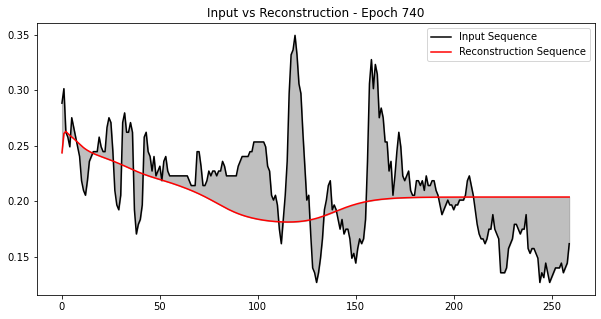

Epoch 741: train loss 13.672059154510498 val loss 13.447765630834242
Epoch 742: train loss 13.228828087974998 val loss 12.950062566645006
Epoch 743: train loss 13.44878556027132 val loss 12.851764681760002
Epoch 744: train loss 12.987816011204439 val loss 12.79365187813254
Epoch 745: train loss 12.968445334715001 val loss 12.865249886232263
Epoch 746: train loss 13.125424631904153 val loss 12.636575766170726
Epoch 747: train loss 12.669703208698946 val loss 12.600029378778794
Epoch 748: train loss 12.792065160414753 val loss 12.570481283524456
Epoch 749: train loss 13.195806239632999 val loss 13.14966178781846
Epoch 750: train loss 13.131462820838479 val loss 13.766399938919966
Epoch 751: train loss 13.008912703570198 val loss 12.715051763197955
Epoch 752: train loss 12.927734313291662 val loss 13.053146126691033
Epoch 753: train loss 12.830851756825167 val loss 12.625753066119026
Epoch 754: train loss 12.885600432227639 val loss 12.671024075676414
Epoch 755: train loss 12.857486736073

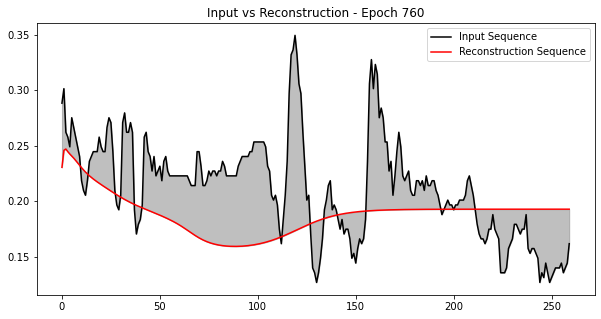

Saving best model
Epoch 761: train loss 12.556673134074492 val loss 12.455194776198443
Saving best model
Epoch 762: train loss 12.550533098333021 val loss 12.334743146335377
Epoch 763: train loss 12.648051929473876 val loss 12.430327959621653
Epoch 764: train loss 12.535927811790915 val loss 12.536633996402516
Epoch 765: train loss 12.627490312912885 val loss 12.651194897819968
Epoch 766: train loss 12.597166521408978 val loss 12.54808650858262
Epoch 767: train loss 12.622951827329748 val loss 12.56467457378612
Epoch 768: train loss 13.137046858843636 val loss 12.52559837733998
Epoch 769: train loss 12.466269762375775 val loss 12.759215444677016
Epoch 770: train loss 12.792416768915514 val loss 12.35354180055506
Epoch 771: train loss 12.712880364586326 val loss 12.506772815479952
Epoch 772: train loss 12.542486291773178 val loss 12.510867775187773
Epoch 773: train loss 12.622162701101864 val loss 12.389909062666051
Epoch 774: train loss 12.539742750280043 val loss 12.802962695851045
Sa

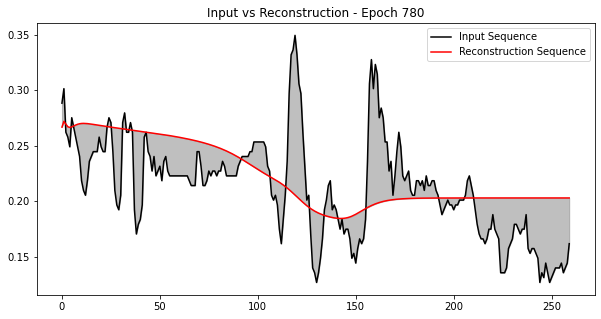

Epoch 781: train loss 12.520395971747005 val loss 12.306297459321863
Epoch 782: train loss 12.416292182136985 val loss 12.161551043566536
Epoch 783: train loss 12.406135183222153 val loss 12.361002983766443
Epoch 784: train loss 12.521599461050595 val loss 12.167171761568856
Epoch 785: train loss 12.636357834759881 val loss 12.118406231263105
Epoch 786: train loss 12.277802798327278 val loss 12.224543431225944
Epoch 787: train loss 12.44093713760376 val loss 12.106832700617174
Epoch 788: train loss 12.474830666710348 val loss 12.10012162432951
Epoch 789: train loss 12.552510530808393 val loss 12.652404459785012
Epoch 790: train loss 12.58754961350385 val loss 12.09435531391817
Saving best model
Epoch 791: train loss 12.356789510390337 val loss 12.073238585976993
Epoch 792: train loss 12.221545589671415 val loss 12.076166119295008
Saving best model
Epoch 793: train loss 12.572051255843219 val loss 11.992423063166001
Epoch 794: train loss 12.248030275457046 val loss 12.110825603148516
Ep

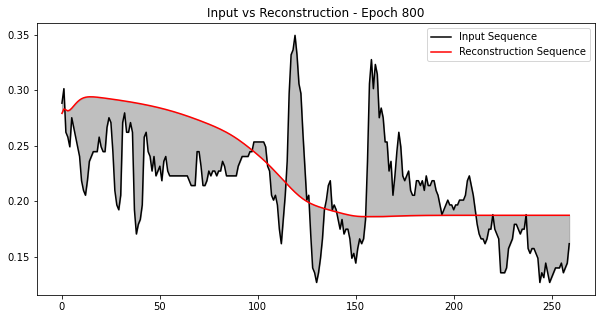

Saving best model
Epoch 801: train loss 12.217871688393986 val loss 11.929285069072948
Epoch 802: train loss 12.394982250999002 val loss 12.395852285272936
Epoch 803: train loss 12.426332224116607 val loss 12.042475470374612
Epoch 804: train loss 12.298122563081629 val loss 12.158899840186624
Epoch 805: train loss 12.224166875727036 val loss 12.215312242507935
Epoch 806: train loss 12.44986728219425 val loss 12.056344896204331
Epoch 807: train loss 12.155904652090634 val loss 11.938438524919398
Epoch 808: train loss 12.176967971465167 val loss 12.295172932568718
Epoch 809: train loss 12.281529465843649 val loss 12.648836651970358
Epoch 810: train loss 12.261379073647891 val loss 11.987842747744391
Epoch 811: train loss 12.149715000040391 val loss 12.148777238060447
Epoch 812: train loss 12.329362700967227 val loss 12.224883034650016
Epoch 813: train loss 12.424029024909524 val loss 12.14732460975647
Epoch 814: train loss 12.36082467471852 val loss 12.047699880599975
Saving best model
E

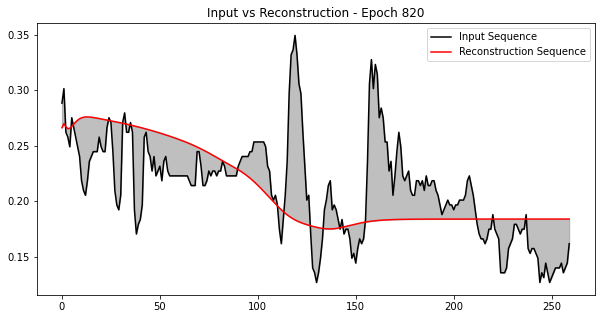

Epoch 821: train loss 12.157425313837388 val loss 11.96117675444659
Epoch 822: train loss 12.331537846957936 val loss 12.253995362450095
Epoch 823: train loss 12.403178719913258 val loss 11.994001147326301
Epoch 824: train loss 12.115624051935532 val loss 11.936808709537281
Epoch 825: train loss 12.052819510067211 val loss 11.91545949823716
Epoch 826: train loss 12.149268632776597 val loss 12.140826797485351
Epoch 827: train loss 12.191368708891027 val loss 12.391844626034008
Epoch 828: train loss 12.363900347316966 val loss 11.881794043148265
Epoch 829: train loss 12.051926466997932 val loss 11.918237461763269
Epoch 830: train loss 12.030852385128245 val loss 11.959224151162541
Saving best model
Epoch 831: train loss 12.185692764731014 val loss 11.840914322348201
Epoch 832: train loss 12.228508433173685 val loss 12.079027882744285
Epoch 833: train loss 12.185378876854392 val loss 12.062376468321856
Saving best model
Epoch 834: train loss 12.11177972905776 val loss 11.814059723124785
E

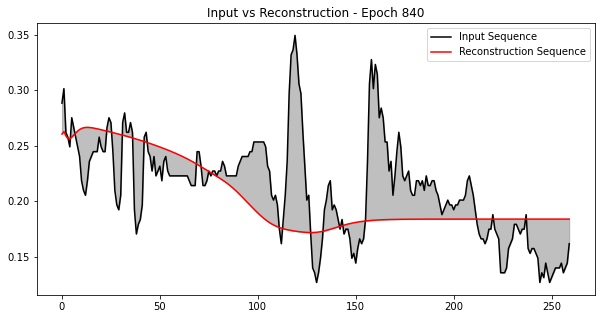

Epoch 841: train loss 12.096901268117568 val loss 12.031475201775047
Epoch 842: train loss 11.942637729644776 val loss 11.822765013750862
Epoch 843: train loss 12.204925178079044 val loss 12.215156886156867
Epoch 844: train loss 12.080643446305219 val loss 12.018810726614559
Epoch 845: train loss 12.068446120093851 val loss 11.892629901100607
Epoch 846: train loss 11.978357334697948 val loss 11.780746207517737
Epoch 847: train loss 11.962112679201013 val loss 12.37539622923907
Epoch 848: train loss 12.218001068339628 val loss 11.903330449496998
Epoch 849: train loss 12.651426001156077 val loss 12.854879917817957
Epoch 850: train loss 13.02628537346335 val loss 12.607731875251321
Epoch 851: train loss 12.527245179344627 val loss 12.267737798129811
Epoch 852: train loss 12.52416395299575 val loss 13.144434822306913
Epoch 853: train loss 12.631293566086713 val loss 12.150991927876191
Epoch 854: train loss 13.478328800201416 val loss 13.345269522947424
Epoch 855: train loss 14.946728162204

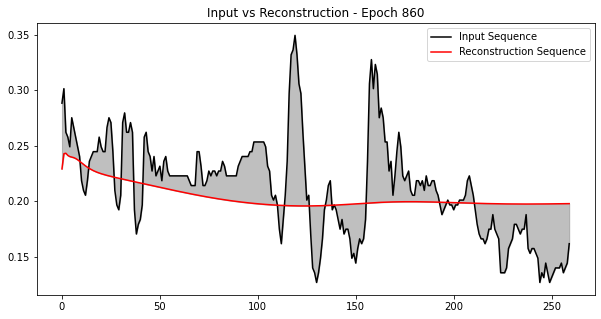

Epoch 861: train loss 12.40496909197639 val loss 12.57895180758308
Epoch 862: train loss 12.59941754060633 val loss 12.304507850198185
Epoch 863: train loss 12.405727448182947 val loss 12.047909977856804
Epoch 864: train loss 12.314010356454288 val loss 12.240882823046515
Epoch 865: train loss 12.33516009835636 val loss 12.32798563452328
Epoch 866: train loss 12.372895549325381 val loss 12.360109929477467
Epoch 867: train loss 12.43041799769682 val loss 12.191443471347585
Epoch 868: train loss 12.266358745799344 val loss 12.084932972403134
Epoch 869: train loss 12.303454320571001 val loss 12.08546464022468
Epoch 870: train loss 12.21407943613389 val loss 12.02530460357666
Epoch 871: train loss 12.363803526934456 val loss 12.232410526275634
Epoch 872: train loss 12.118101142434513 val loss 12.008800725375904
Epoch 873: train loss 12.214741751726937 val loss 12.10479180392097
Epoch 874: train loss 12.241680122824276 val loss 12.160912059335148
Epoch 875: train loss 12.20712589376113 val 

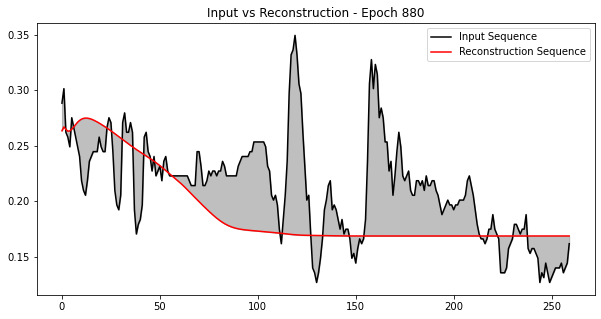

Epoch 881: train loss 12.31649709589341 val loss 12.474527342179242
Epoch 882: train loss 12.22660993127262 val loss 12.661047559625962
Epoch 883: train loss 12.128056374718161 val loss 11.921133717368631
Epoch 884: train loss 12.060459880267873 val loss 11.979749351389268
Epoch 885: train loss 12.160684574351592 val loss 11.93716355492087
Epoch 886: train loss 12.110781944499296 val loss 12.036561713499182
Epoch 887: train loss 12.049013547336354 val loss 11.886078464283663
Epoch 888: train loss 12.035427626441507 val loss 11.964806960610783
Epoch 889: train loss 12.028447386797737 val loss 11.746139038310332
Epoch 890: train loss 12.190506856581743 val loss 11.93783960903392
Epoch 891: train loss 12.211549164267147 val loss 12.032376783034382
Epoch 892: train loss 11.961191070781034 val loss 11.861651448642506
Epoch 893: train loss 11.997156788321103 val loss 12.009154726477231
Epoch 894: train loss 12.012450605280259 val loss 11.803075919431798
Epoch 895: train loss 11.9556057312909

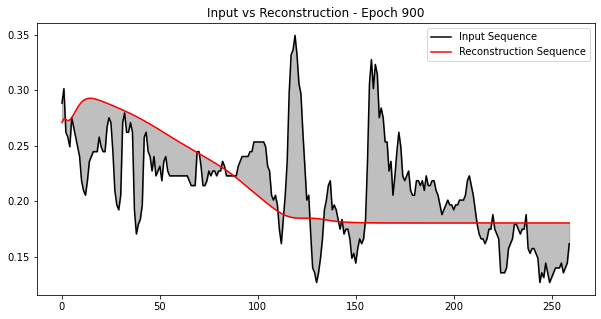

Epoch 901: train loss 11.921640979542452 val loss 12.21416384192074
Epoch 902: train loss 11.976936637654024 val loss 11.83886381037095
Epoch 903: train loss 11.88920534358305 val loss 11.833827989241657
Epoch 904: train loss 12.021383481867174 val loss 11.991562007455265
Epoch 905: train loss 12.263930130004884 val loss 12.073885250091553
Epoch 906: train loss 12.135049320669735 val loss 11.932591830982881
Epoch 907: train loss 11.888912975086885 val loss 11.761973899953505
Epoch 908: train loss 11.844500996084774 val loss 11.842754829631133
Epoch 909: train loss 11.77979798597448 val loss 11.799650960810045
Saving best model
Epoch 910: train loss 12.000241049598245 val loss 11.69994348638198
Epoch 911: train loss 11.965121050441967 val loss 12.371358944387996
Saving best model
Epoch 912: train loss 11.855277689765481 val loss 11.680769123750574
Epoch 913: train loss 11.860230832941392 val loss 12.368416730095358
Epoch 914: train loss 11.808519823410931 val loss 12.051997942083021
Epo

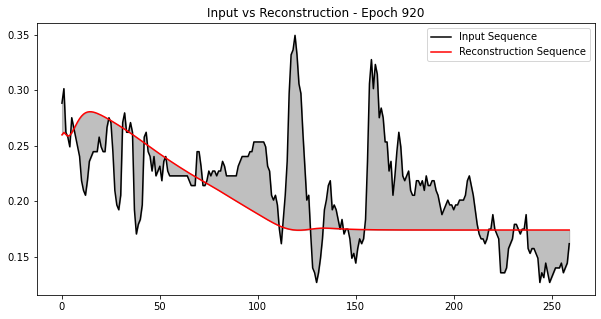

Epoch 921: train loss 12.063668682995964 val loss 11.770755400377162
Epoch 922: train loss 11.65431848413804 val loss 11.870161572624655
Saving best model
Epoch 923: train loss 11.730985518062816 val loss 11.580453306085923
Saving best model
Epoch 924: train loss 11.608280456767362 val loss 11.521891246122472
Epoch 925: train loss 11.981664292952594 val loss 12.416352272033691
Epoch 926: train loss 12.819808236290427 val loss 12.250353757072897
Epoch 927: train loss 12.324272526011747 val loss 12.431135031756233
Epoch 928: train loss 12.200985437280991 val loss 12.032427613875445
Epoch 929: train loss 11.977738604826087 val loss 11.68441188475665
Epoch 930: train loss 12.030028382469625 val loss 11.955581277959487
Epoch 931: train loss 11.845366960413315 val loss 11.92944268058328
Epoch 932: train loss 11.880245769725127 val loss 11.820488379983342
Epoch 933: train loss 11.831500720977782 val loss 11.896570407643038
Epoch 934: train loss 11.674445343017577 val loss 11.574832181369556
E

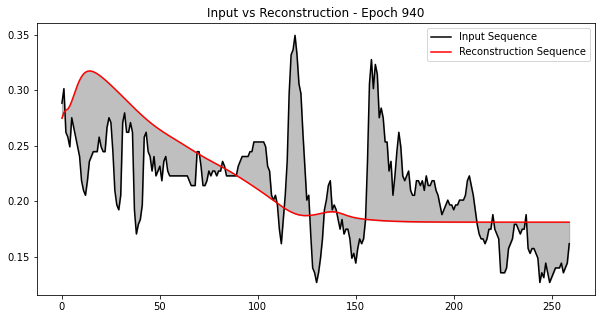

Epoch 941: train loss 11.936841706668629 val loss 11.65626723906573
Epoch 942: train loss 11.76853322982788 val loss 11.573648747275858
Epoch 943: train loss 11.684951512953814 val loss 11.805344059888053
Epoch 944: train loss 11.72974983103135 val loss 11.572487146714154
Epoch 945: train loss 11.641829900180593 val loss 11.572007291457233
Epoch 946: train loss 11.61585438672234 val loss 11.661309783598956
Epoch 947: train loss 11.968378560683307 val loss 11.664598537893855
Epoch 948: train loss 11.807957121905158 val loss 11.688801187627456
Epoch 949: train loss 12.081614011876724 val loss 12.79858964471256
Epoch 950: train loss 14.352562354592717 val loss 17.82941545598647
Epoch 951: train loss 18.782973957061767 val loss 17.87298775841208
Epoch 952: train loss 18.260009126102222 val loss 17.596037578582763
Epoch 953: train loss 18.031501702701345 val loss 17.46452720305499
Epoch 954: train loss 17.84866770576028 val loss 17.298447956758388
Epoch 955: train loss 17.60585447760189 val

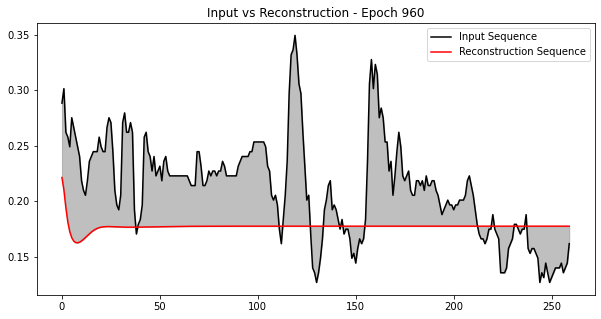

Epoch 961: train loss 18.17699484544642 val loss 15.692994342130774
Epoch 962: train loss 15.551078156863943 val loss 15.23519743751077
Epoch 963: train loss 15.31370179793414 val loss 15.419338669496424
Epoch 964: train loss 16.774294516619513 val loss 18.47781623391544
Epoch 965: train loss 18.701072373109707 val loss 17.85540636287016
Epoch 966: train loss 18.150890552296357 val loss 17.65003251468434
Epoch 967: train loss 17.718427904914407 val loss 17.11102524925681
Epoch 968: train loss 16.50381197087905 val loss 15.223001676447252
Epoch 969: train loss 14.781235117070816 val loss 14.598176075430477
Epoch 970: train loss 16.410636868196374 val loss 16.598466099009794
Epoch 971: train loss 15.172784564074348 val loss 14.526279830932618
Epoch 972: train loss 14.527973449931425 val loss 14.349565764034496
Epoch 973: train loss 15.096681858511532 val loss 14.901573938481947
Epoch 974: train loss 14.960865907108083 val loss 16.36952765408684
Epoch 975: train loss 14.828021672192742 va

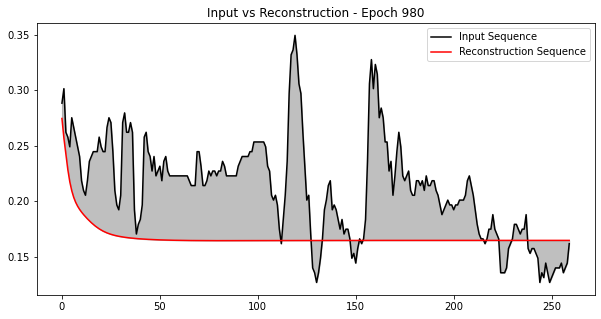

Epoch 981: train loss 18.92876214981079 val loss 17.609499914505903
Epoch 982: train loss 18.04383525287404 val loss 17.59491512635175
Epoch 983: train loss 17.982103807785933 val loss 17.582409118203557
Epoch 984: train loss 17.935724449157714 val loss 17.570140434713924
Epoch 985: train loss 17.897367208144242 val loss 17.552287847855514
Epoch 986: train loss 17.866984378590303 val loss 17.53379513235653
Epoch 987: train loss 17.83521213531494 val loss 17.513943004608155
Epoch 988: train loss 17.80544631060432 val loss 17.481536870844224
Epoch 989: train loss 17.768676578297335 val loss 17.443334585077622
Epoch 990: train loss 17.73456495509428 val loss 17.39872257569257
Epoch 991: train loss 17.697183210709515 val loss 17.336965499204748
Epoch 992: train loss 17.647911071777344 val loss 17.260313982122085
Epoch 993: train loss 17.601425496269673 val loss 17.135481088301713
Epoch 994: train loss 17.518887042999268 val loss 16.962708422716926
Epoch 995: train loss 17.36560822094188 va

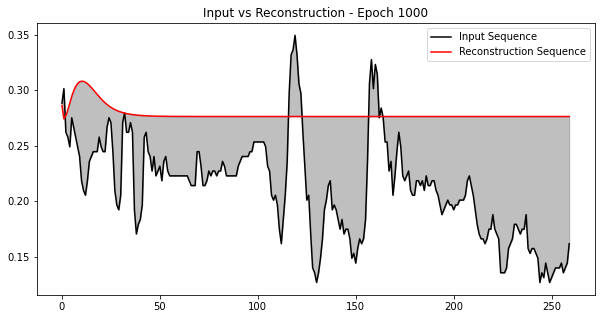

In [70]:
save_path = 'best_model.pth'  # Replace with your actual path
model, history = train_model(model, train_dataset, train_dataset, 1000, save_path)

In [132]:
len(train_dataset)

85

In [73]:
model.encoder.forward(train_dataset[0])

tensor([[ 0.4429, -0.3193, -0.0844, -0.0171, -0.0156, -0.3747, -0.0063, -0.0603,
         -0.4113, -0.0298, -0.0924,  0.0273,  0.3491, -0.4525,  0.5644, -0.1009,
         -0.6832, -0.6441, -0.3632, -0.2323, -0.2801,  0.7019,  0.5927,  0.4714,
          0.0113,  0.1182, -0.5687, -0.2087, -0.1995,  0.0849,  0.1256,  0.3348,
          0.0845, -0.0016,  0.1306,  0.0906, -0.2467, -0.0547,  0.3803, -0.0410,
          0.4877, -0.8448,  0.5158, -0.0530, -0.4597,  0.3881, -0.6508, -0.0205,
          0.6038,  0.0683,  0.0264,  0.0127, -0.0072, -0.1801, -0.6158,  0.4679,
          0.0973,  0.1307, -0.0953,  0.0641, -0.8192,  0.0030, -0.3171, -0.0220]],
       grad_fn=<ViewBackward0>)

In [75]:
model.eval()

Autoencoder(
  (encoder): Encoder(
    (rnn2): LSTM(1, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn2): LSTM(64, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [133]:
labels = labels[:85]

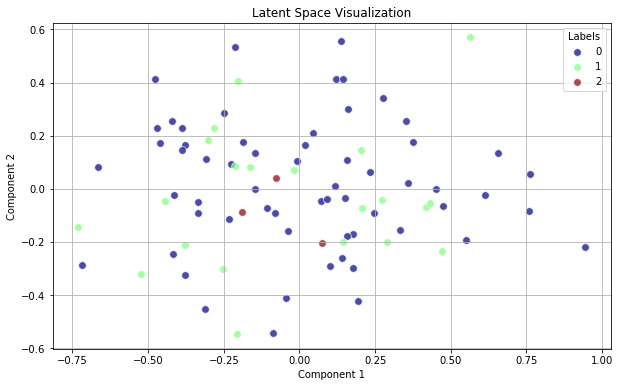

In [134]:
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming model and dataloader are already defined
model.eval()  # Set the model to evaluation mode

# Function to extract latent vectors
def get_latent_vectors(encoder, dataloader):
    with torch.no_grad():  # No need to track gradients
        latent_vectors = []
        for data in dataloader:
            inputs = data.to(device)  # Adjust depending on your dataloader structure
            latent = encoder(inputs)
            latent_vectors.append(latent.cpu().numpy())  # Move tensors to CPU and convert to numpy
    return np.concatenate(latent_vectors, axis=0)

# Assuming you have a DataLoader called dataloader
latent_vectors = get_latent_vectors(model.encoder, train_dataset)

# Dimensionality Reduction
pca = PCA(n_components=2)  # Reduce to 2 dimensions for plotting
latent_2d = pca.fit_transform(latent_vectors)

# Alternatively, using t-SNE for a more complex but possibly clearer visualization
# tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
# latent_2d = tsne.fit_transform(latent_vectors)

# Plotting
plt.figure(figsize=(10, 6))
for label, color in label_to_color.items():
    idx = labels == label
    plt.scatter(latent_2d[idx, 0], latent_2d[idx, 1], color=color, label=str(label), alpha=0.7, edgecolors='w', s=60)
plt.title('Latent Space Visualization')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.legend(title='Labels')
plt.show()

In [96]:
len(train_dataset)

85

In [91]:
# Define a colormap for the labels
unique_labels = np.unique(labels[:100])
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))  # Use jet colormap or choose another
label_to_color = dict(zip(unique_labels, colors))


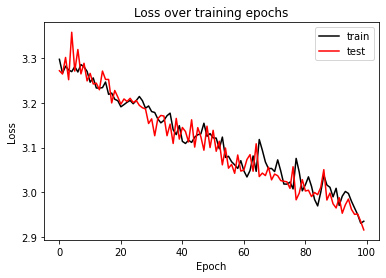

In [248]:
ax = plt.figure().gca()

ax.plot(history['train'],label='Train Loss', color='black')
ax.plot(history['val'],label='Val Loss', color='red')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

### ECG Anomaly Detection Model Evaluation and Visualization in PyTorch

The code in this section performs the evaluation and visualization stages for an ECG anomaly detection model using PyTorch. It focuses on assessing the model's ability to differentiate between normal and anomalous ECG sequences and visually representing its predictions.

1. **Model Loading and Preparation**:
    - The pre-trained Autoencoder model is loaded with its optimal weights from a saved state, ensuring it is ready for evaluation.
    - The model is transferred to the appropriate device (GPU/CPU) and set to evaluation mode.

2. **Prediction Function**:
    - `predict` is a function designed to process a dataset through the model, computing the reconstruction loss for each sequence.
    - It outputs both the reconstructed sequences and their corresponding losses, which are crucial metrics for evaluating the model's performance.

3. **Loss Distribution Visualization**:
    - The reconstruction losses for the training dataset are visualized using a distribution plot, providing insight into the model's performance during training.
    - A threshold (25 in this case) is set to differentiate between normal and anomalous readings based on the loss.

4. **Model Performance on Test Data**:
    - The model's effectiveness is tested on a 'normal' test dataset, with the distribution of reconstruction losses plotted. This helps in understanding how the model performs on unseen but normal ECG data.
    - The number of correctly identified normal sequences is calculated and displayed, offering a quantitative measure of performance.

5. **Anomaly Detection and Visualization**:
    - The model is then evaluated on an 'anomaly' dataset to test its ability to identify anomalies.
    - A distribution plot for the losses on the anomaly dataset is created, with anomalies expected to have higher reconstruction losses.
    - The number of correctly identified anomalies is calculated, providing a metric for the model's sensitivity to abnormalities.

6. **Individual Predictions Visualization**:
    - `plot_prediction` is a function that visualizes the original and reconstructed ECG sequences, along with their reconstruction loss. This visualization is instrumental in understanding the model's performance on an individual sequence level.
    - The script creates a series of plots for both normal and anomalous ECG sequences from the test datasets, allowing for a direct visual comparison of the model's predictions against the actual data.

This comprehensive evaluation and visualization approach enables a thorough understanding of the model's capabilities and limitations in real-world scenarios. It offers an in-depth analysis of how effectively the model can identify and distinguish between normal and anomalous ECG patterns, which is critical for its application in healthcare monitoring systems.

In [250]:
model = Autoencoder(seq_len, n_features, 36)

model.load_state_dict(torch.load('best_model.pth'))

model = model.to(device)
model.eval()

Autoencoder(
  (encoder): Encoder(
    (rnn2): LSTM(1, 36, batch_first=True)
  )
  (decoder): Decoder(
    (rnn2): LSTM(36, 72, batch_first=True)
    (output_layer): Linear(in_features=72, out_features=1, bias=True)
  )
)

In [348]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses


OptionError: "No such keys(s): 'mode.use_inf_as_null'"

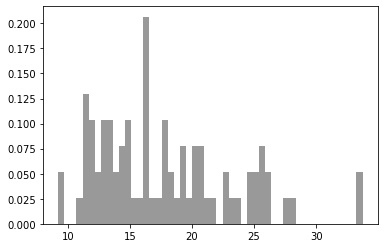

In [349]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True, label='Train',color='black');

#Visualising train loss

In [350]:
Threshold = 25

OptionError: "No such keys(s): 'mode.use_inf_as_null'"

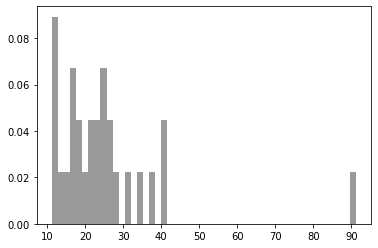

In [351]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True,color='black');

In [352]:
correct = sum(l <= 25 for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 18/28


In [353]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]


In [354]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True,color='red');


RuntimeError: shape '[1, 122, 1]' is invalid for input of size 140

In [355]:
correct = sum(l > 25 for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 10/28


In [356]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true',color='black')
  ax.plot(predictions[0], label='reconstructed',color='red')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

RuntimeError: shape '[1, 122, 1]' is invalid for input of size 140

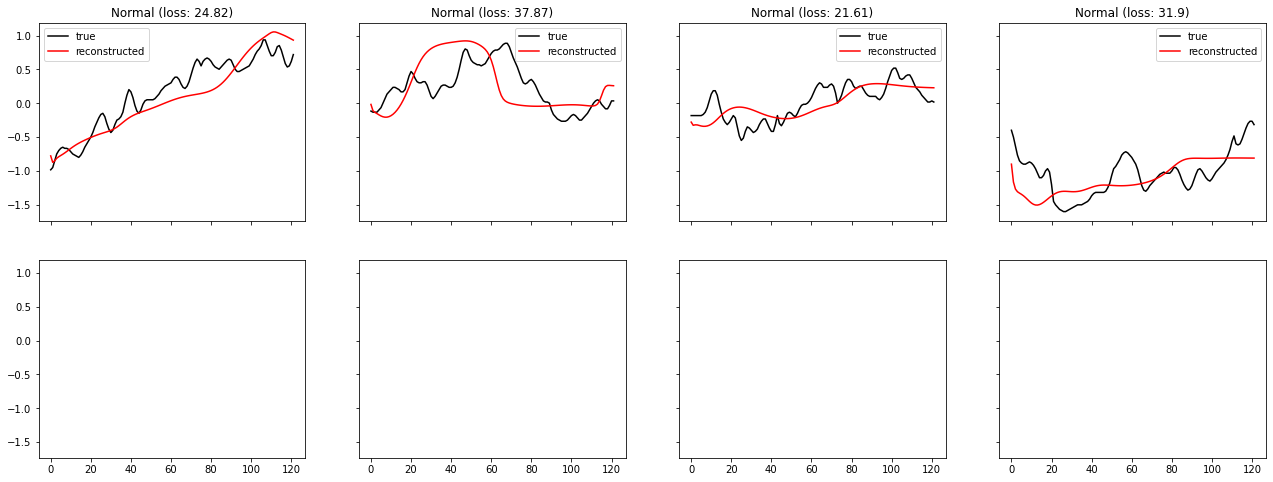

In [357]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=4,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:4]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:4]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();

RuntimeError: shape '[1, 122, 1]' is invalid for input of size 140

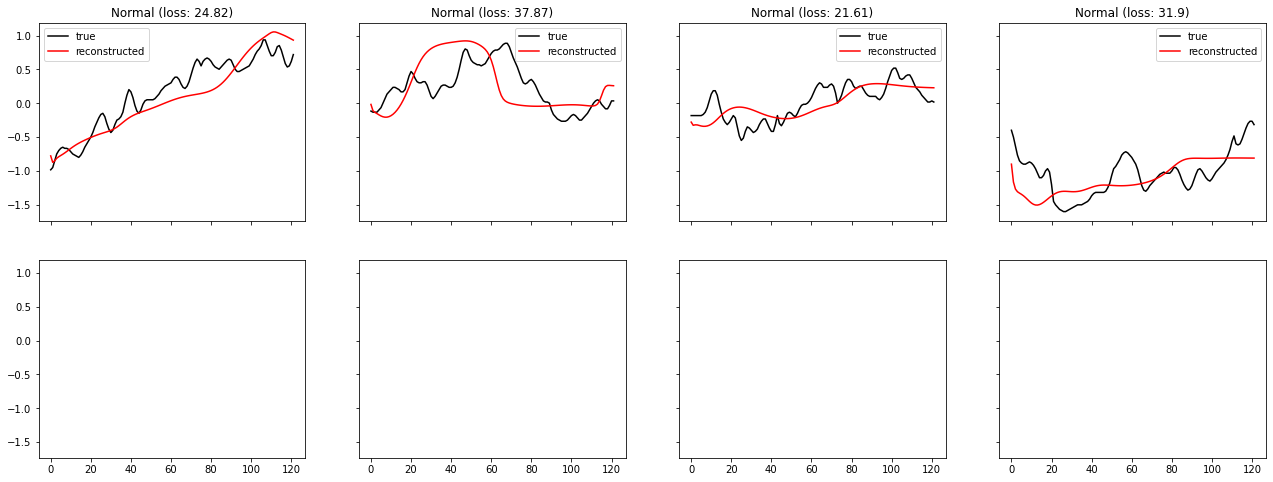

In [358]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=4,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:4]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:4]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();